---

## Matthieu Kaeppelin

## Kaggle challenge - Segmentation and classification of skin lesion

## Télécom 2024

---

## Introduction

Today, skin cancer is a public health and economic problem. Several studies indicate that skin diseases are one of the most common human ailments, affecting all ages, sexes and many cultures. The recommended method for early detection of skin disease is to be alert to new or changing skin growth. One of the most commonly used techniques for analysing skin lesions is ABCD analysis, which involves scanning the skin area of interest for asymmetry (A), border irregularity (B), colour variation (C) and diameter (D).

The emergence of powerful machine learning techniques such as Deep Learning has also enabled the development of intelligent medical image analysis systems which, thanks to the use of artificial and convolutional neural networks, have demonstrated remarkable performance compared with standard methods.

Given this context, this project will focus on the application of Deep Learning and ABCD feature extraction. These two methods will be compared for classification, while segmentation takes place through a single pipeline.

Translated with DeepL.com (free version)

--------

## Contents

1. Importing libraries

2. Importing training and test data

3. Dataset exploration

4. Data pre-processing

5. Determination of the segmentation mask

6. Feature extraction

7. Image classification using Random Forest

8. Image classification using CNN - AlexNet

# I - Importing libraries

In [1]:
import matplotlib.pyplot as plt  # Pour la visualisation des données
from imblearn.over_sampling import RandomOverSampler # Pour la suréchantillonnage
import io # Pour les opérations d'entrée/sortie
import imageio as io  # Pour lire les images
import numpy as np  # Pour les opérations mathématiques
import warnings # Pour ignorer les avertissements
import AlexNet as an  # Pour le modèle AlexNet
import pandas as pd  # Pour la manipulation des données
from skimage import io  # Pour lire les images
import cv2 as cv  # Pour le traitement d'image
import os  # Pour les opérations liées au système d'exploitation
import DarkArtefactRemoval as dca  # Pour la suppression des artefacts sombres
import dullrazor as dr  # Pour la suppression des poils
import segmentation_and_preprocessing as sp  # Pour la segmentation et le prétraitement des images
from tqdm import tqdm  # Pour la barre de progression
import compute_features as cf  # Pour calculer les caractéristiques des images
from sklearn.model_selection import train_test_split  # Pour diviser les données en ensembles d'entraînement et de test
import tensorflow as tf  # Pour le machine learning
from tensorflow.keras import layers, models  # Pour la création de modèles de machine learning
import csv  # Pour lire et écrire des fichiers CSV
import glob  # Pour lire les fichiers dans un répertoire
import torch  # Pour le machine learning
import torch.nn as nn  # Pour la création de modèles de machine learning
import torch.nn.functional as F  # Pour les fonctions d'activation et autres fonctions utiles
import torch.optim as optim  # Pour les optimiseurs
import torchvision.datasets as datasets  # Pour charger des ensembles de données
import torchvision.transforms as transforms  # Pour les transformations d'image
from keras.callbacks import Callback  # Pour les callbacks lors de l'entraînement des modèles
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Pour la génération de données d'image
import seaborn as sns  # Pour la visualisation des données
from sklearn.metrics import confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, classification_report  # Pour les métriques d'évaluation
from keras.models import Sequential # Pour la création de modèles de machine learning
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization # Pour les couches des modèles

# Print the version of all the module I used
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("OpenCV version: ", cv.__version__)
print("TensorFlow version: ", tf.__version__)
print("Torch version: ", torch.__version__)
print("Seaborn version: ", sns.__version__)



Numpy version:  1.24.3
Pandas version:  1.5.3
OpenCV version:  4.8.1
TensorFlow version:  2.15.0
Torch version:  2.2.2
Seaborn version:  0.12.2


# II -  Loading Data

In [2]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'  # Chemin vers le répertoire d'entraînement
image_dir_test = 'Test/Test/'  # Chemin vers le répertoire de test

Train_path = image_dir_train  # Définir le chemin pour les images d'entraînement

# Utiliser glob pour obtenir une liste de tous les fichiers jpg et png dans le répertoire d'entraînement
images_train = glob.glob(Train_path + '/*[0-9].jpg')  # Images d'entraînement
mask_img_train = glob.glob(Train_path + '/*seg.png')  # Masques d'entraînement

# Créer une liste d'images d'entraînement qui ont un masque correspondant
images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]

# Utiliser glob pour obtenir une liste de tous les fichiers jpg et png dans le répertoire de test
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')  # Images de test
mask_img_test = glob.glob(image_dir_test + '/*seg.png')  # Masques de test

# Lire les fichiers csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')  # Métadonnées pour l'ensemble d'entraînement
metadataTest = pd.read_csv('metadataTest.csv')  # Métadonnées pour l'ensemble de test


The dataframe and lists containing the metadata and image names have been created above.

In [3]:
print('There are', len(images_train),  'train images')  # Affiche le nombre total d'images d'entraînement
print('There are', len(images_with_mask),  'train images with mask')  # Affiche le nombre d'images d'entraînement qui ont un masque correspondant
print('There are', len(mask_img_train),  'train masks')  # Affiche le nombre total de masques d'entraînement
print('There are', len(images_test),  'test images')  # Affiche le nombre total d'images de test
print('There are', len(mask_img_test),  'test masks')  # Affiche le nombre total de masques de test

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


# III - Exploring Data

### A - First, let's have a look to the images

We are going to face different kind of images in the dataset with different difficulties. We will have to deal with different colors, shapes, sizes, and resolutions. We will have to preprocess the images to make them suitable for the classification and segmentation tasks.

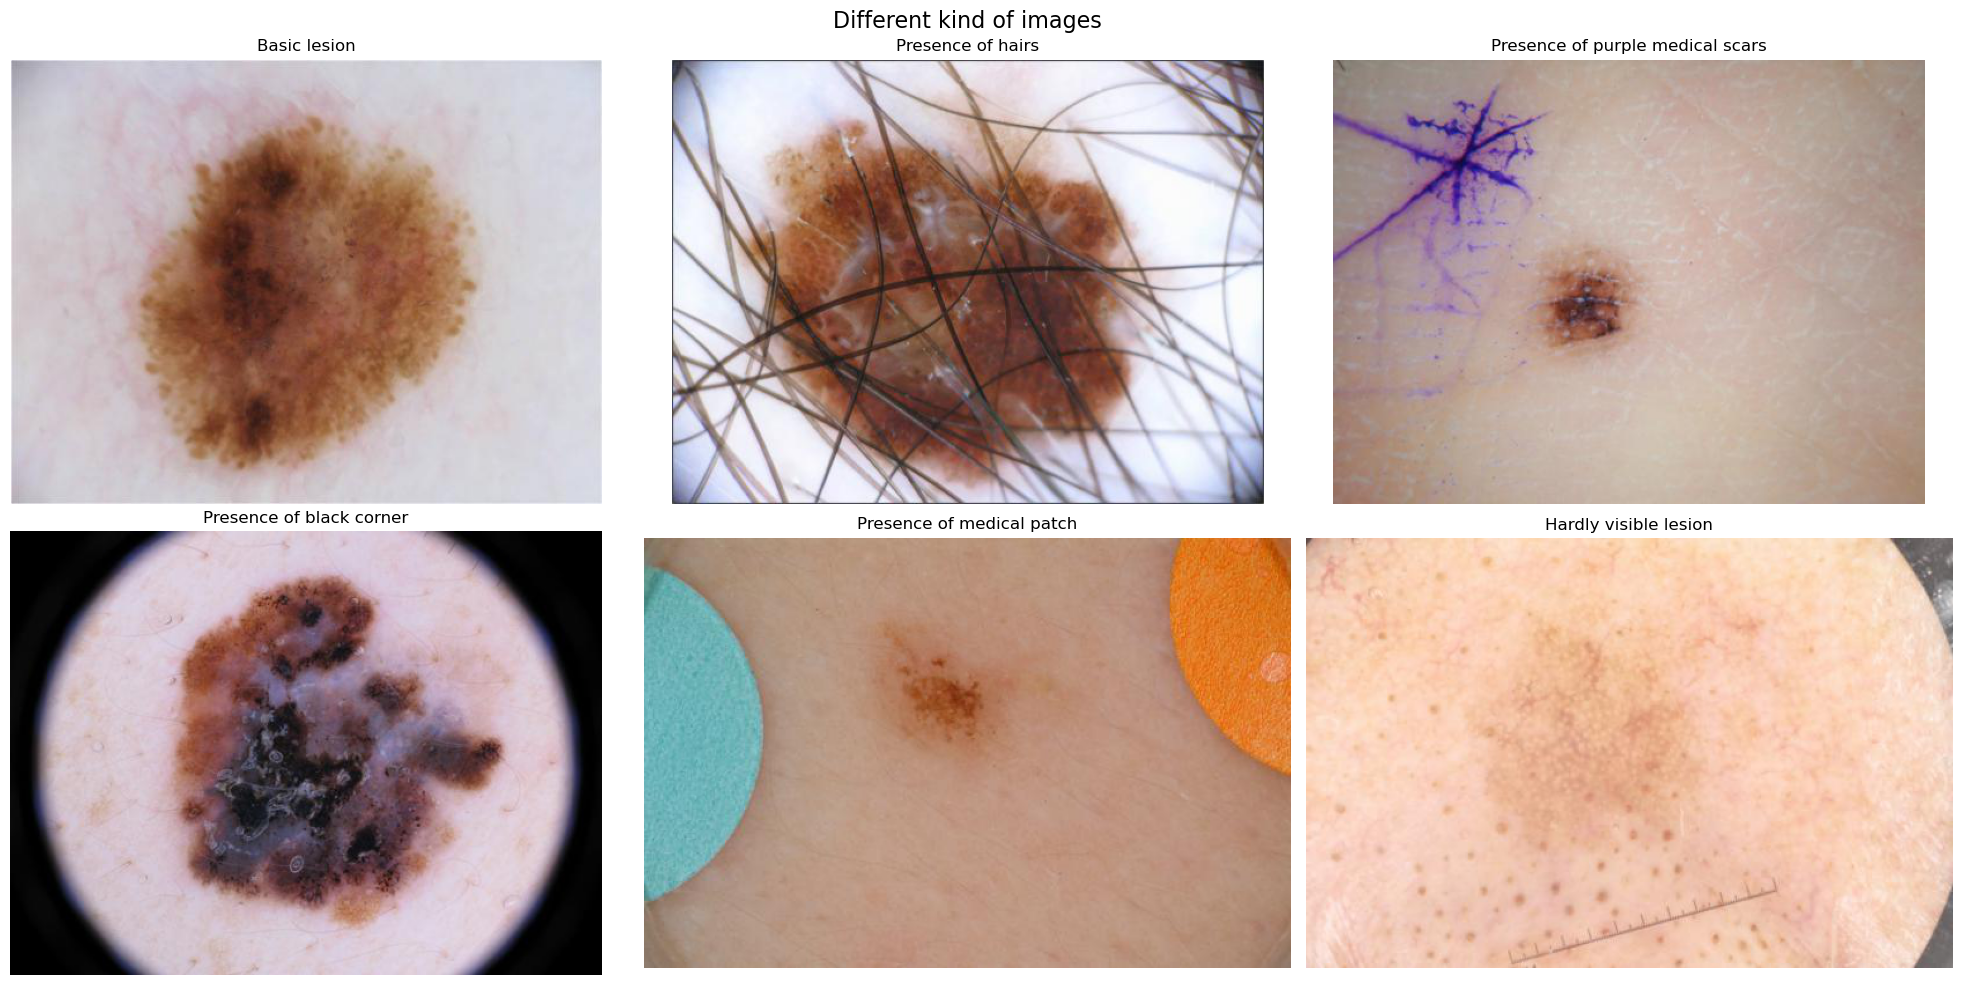

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))  # Créer une grille de 2x2 pour les images

# Charger et afficher la première image
img1 = io.imread('Train/Train/ISIC_0000008.jpg')
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Basic lesion')  # Ajouter un titre
axs[0, 0].axis('off')  # Enlever les axes

# Charger et afficher la deuxième image
img2 = io.imread('Train/Train/ISIC_0000043.jpg')
axs[0, 1].imshow(img2)
axs[0, 1].set_title('Presence of hairs')  # Ajouter un titre
axs[0, 1].axis('off')  # Enlever les axes

# Charger et afficher la troisième image
img3 = io.imread('Train/Train/ISIC_0000140.jpg')
axs[1, 0].imshow(img3)
axs[1, 0].set_title('Presence of black corner')  # Ajouter un titre
axs[1, 0].axis('off')  # Enlever les axes

# Charger et afficher la quatrième image
img4 = io.imread('Train/Train/ISIC_0001275.jpg')
axs[1, 1].imshow(img4)
axs[1, 1].set_title('Presence of medical patch')  # Ajouter un titre
axs[1, 1].axis('off')  # Enlever les axes

# Charger et afficher la cinquième image
img5 = io.imread('Train/Train/ISIC_0010456.jpg')
axs[0, 2].imshow(img5)
axs[0, 2].set_title('Presence of purple medical scars')  # Ajouter un titre
axs[0, 2].axis('off')  # Enlever les axes

# Charger et afficher la sixième image
img6 = io.imread('Train/Train/ISIC_0013459.jpg')
axs[1, 2].imshow(img6)
axs[1, 2].set_title('Hardly visible lesion')  # Ajouter un titre
axs[1, 2].axis('off')  # Enlever les axes


# Ajouter un titre général
fig.suptitle("Different kind of images", fontsize=16)
plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques
plt.show()  # Afficher le graphique

### Let's have a look to the metadata we have

In [5]:
metadataTrain.head()

ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity

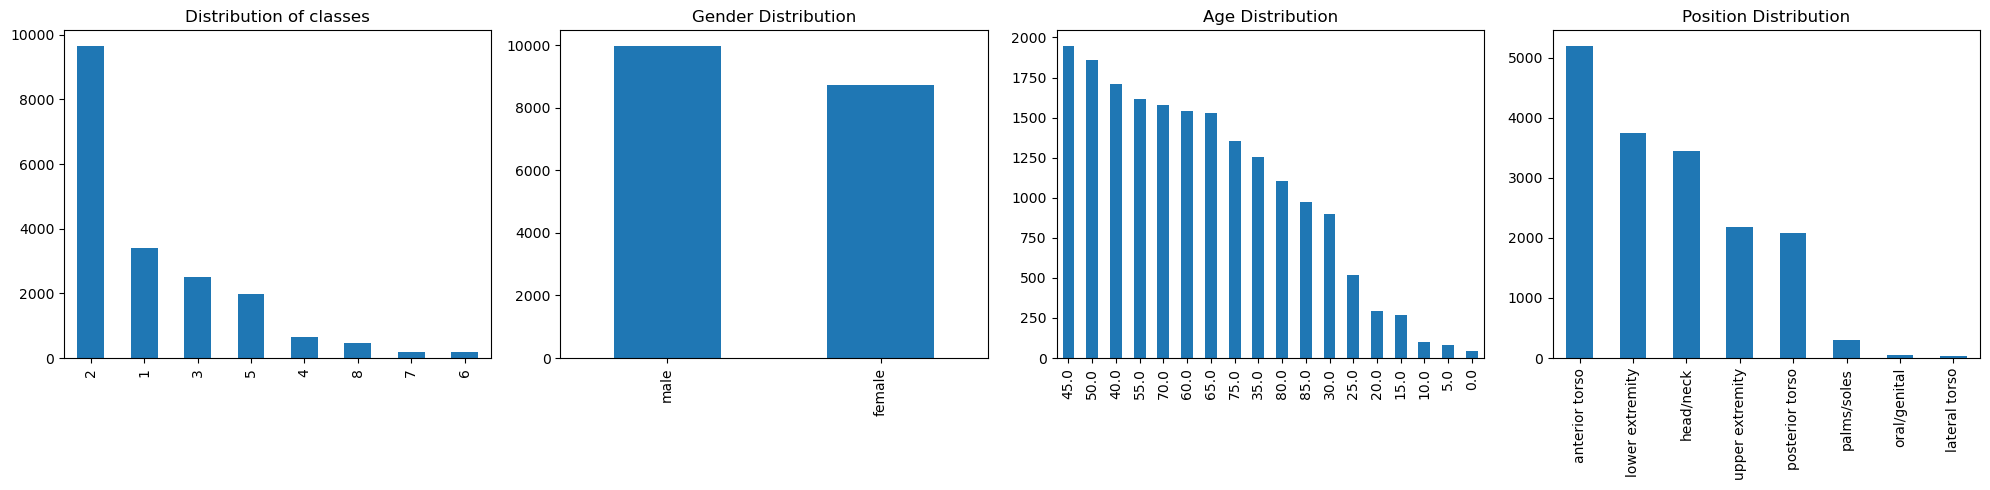

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Créer une grille de 1x4 pour les graphiques

# Afficher la répartition des classes
metadataTrain['CLASS'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribution of classes')

# Afficher la répartition des sexes
metadataTrain['SEX'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Gender Distribution')

# Afficher la répartition des âges
metadataTrain['AGE'].value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('Age Distribution')

# Afficher la répartition des localisations
metadataTrain['POSITION'].value_counts().plot(kind='bar', ax=axs[3])
axs[3].set_title('Position Distribution')

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques
plt.show()  # Afficher le graphique


The precedent distributions show that wxe have an unbalanced dataset with a larg majority of images belonging to the second class. We will have to deal with this unbalance in the classification task.
Three solutions can be considered :
- Oversampling the minority class

- Undersampling the majority class

- Using a weighted loss function like the Weighted Cross Categorization Accuracy:
    -   $WA = \frac{1}{N}\sum_{i=1}^{n} w_i I(y_i =f_i)$ , such that $ \sum{i=1}^{n} w_i = N$

We can also observe that the gender distribution is pretty balanced and that the age distribution and Position ditribution are not balanced.

# IV - Preprocessing Data

### A - Removing Hairs : The dullrazor algorithm

We use the dullrazor algorithm to detect hairs and remove them from the images. The algorithm is based on the following steps:
- Convert the image to grayscale
- Apply a black hat filter to the grayscale image
- Apply a Gaussian Blur
- Apply a binary threshold
- Inpaint the image
- Convert back the image in RGB

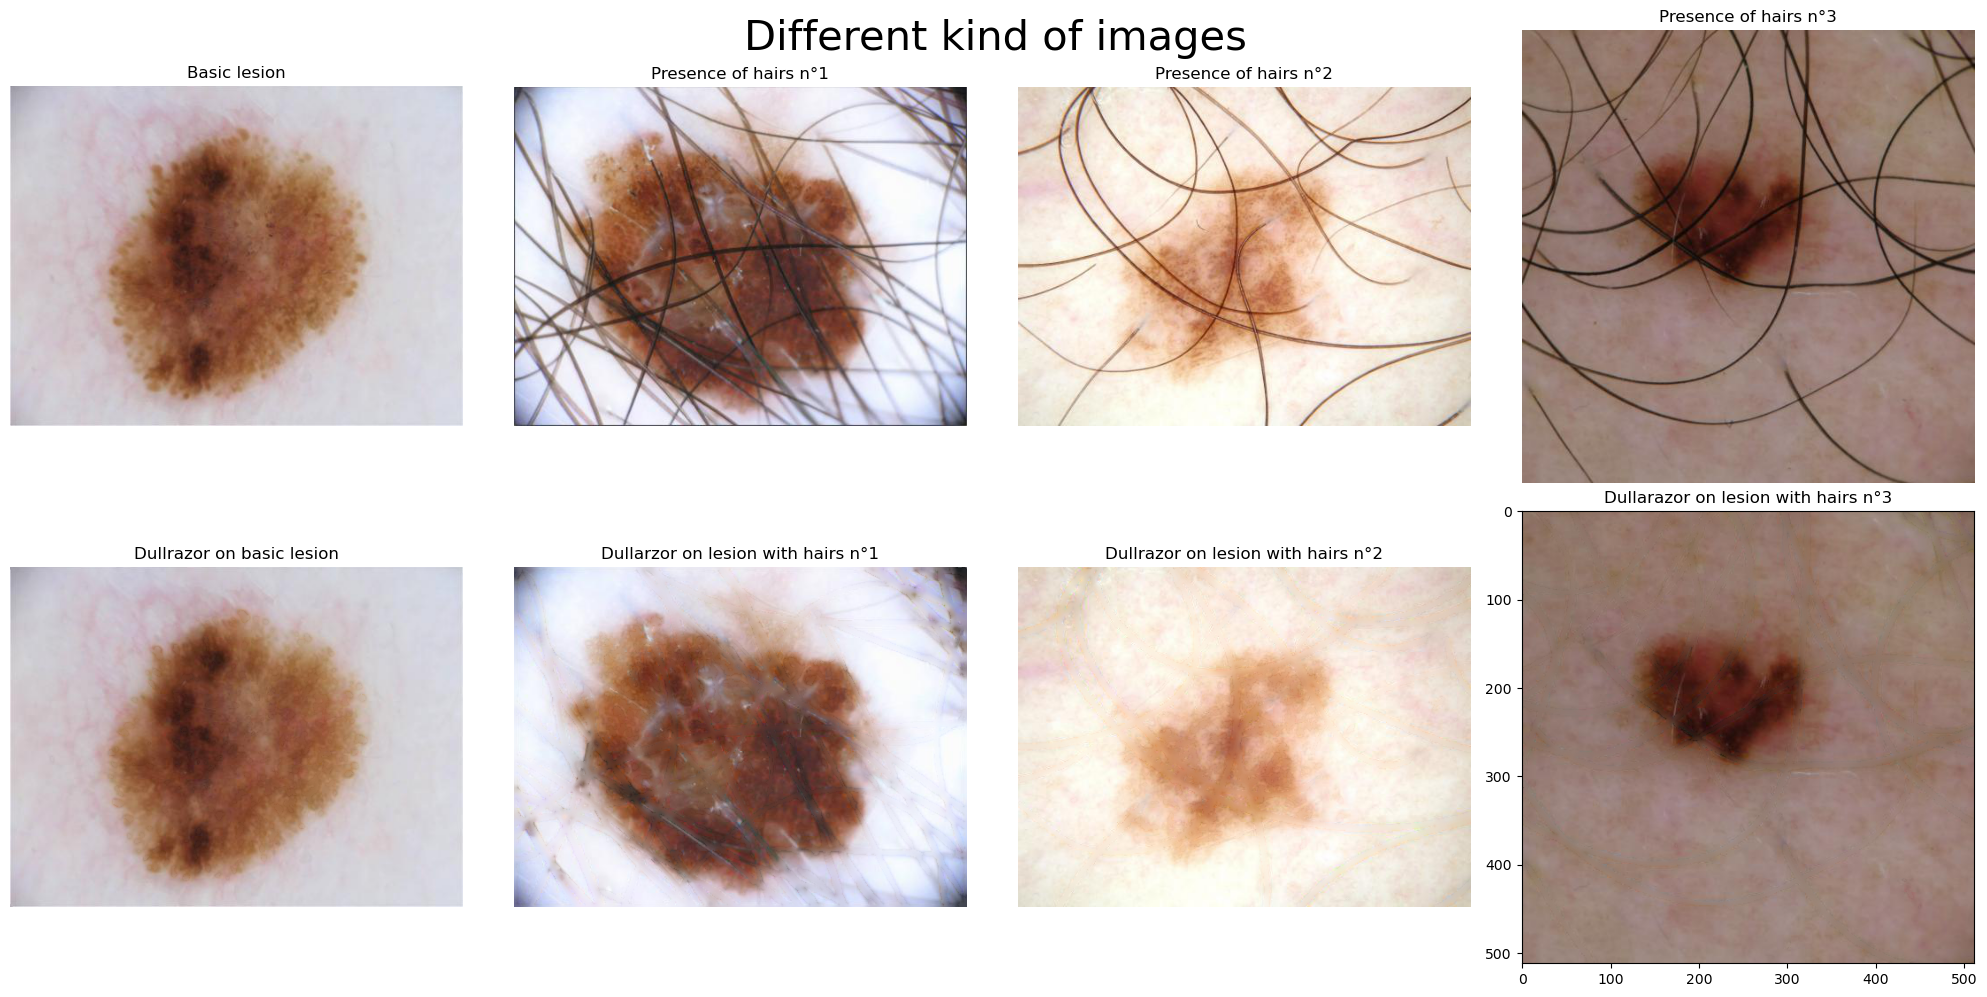

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Créer une grille de 2x4 pour les images

# Charger et afficher la première image
img1 = io.imread('Train/Train/ISIC_0000008.jpg')
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Basic lesion')  # Ajouter un titre
axs[0, 0].axis('off')  # Enlever les axes

# Charger et afficher la deuxième image
img2 = cv.cvtColor(dr.dullrazor(img1), cv.COLOR_BGR2RGB)
axs[1, 0].imshow(img2)
axs[1, 0].set_title('Dullrazor on basic lesion')  # Ajouter un titre
axs[1, 0].axis('off')  # Enlever les axes

# Charger et afficher la troisième image
img3 = io.imread('Train/Train/ISIC_0000043.jpg')
axs[0, 1].imshow(img3)
axs[0, 1].set_title('Presence of hairs n°1')  # Ajouter un titre
axs[0, 1].axis('off')  # Enlever les axes

# Charger et afficher la quatrième image
img4 = cv.cvtColor(dr.dullrazor(img3), cv.COLOR_BGR2RGB)
axs[1, 1].imshow(img4)
axs[1, 1].set_title('Dullarzor on lesion with hairs n°1')  # Ajouter un titre
axs[1, 1].axis('off')  # Enlever les axes

# Charger et afficher la cinquième image
img5 = io.imread('Train/Train/ISIC_0011144.jpg')
axs[0, 2].imshow(img5)
axs[0, 2].set_title('Presence of hairs n°2')  # Ajouter un titre
axs[0, 2].axis('off')  # Enlever les axes

# Charger et afficher la sixième image
img6 = cv.cvtColor(dr.dullrazor(img5), cv.COLOR_BGR2RGB)
axs[1, 2].imshow(img6)
axs[1, 2].set_title('Dullrazor on lesion with hairs n°2')  # Ajouter un titre
axs[1, 2].axis('off')  # Enlever les axes

# Charger et afficher la septième image
img7 = io.imread('Train/Train/ISIC_0061530.jpg')
axs[0, 3].imshow(img7)
axs[0, 3].set_title('Presence of hairs n°3')  # Ajouter un titre
axs[0, 3].axis('off')  # Enlever les axes

# Charger et afficher la huitième image
img8 = cv.cvtColor(dr.dullrazor(img7), cv.COLOR_BGR2RGB)
axs[1, 3].imshow(img8)
axs[1, 3].set_title('Dullarazor on lesion with hairs n°3')  # Ajouter un titre

plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques

# Ajouter un titre général
fig.suptitle("Different kind of images", fontsize=30)

plt.show()  # Afficher le graphique

### B - Remove black corners : The Dark Artefact Removal Algorithm

We use the Dark Artefact Removal Algorithm to remove the black corners from the images. The goal is to remove the black part that are on some of the pictures that would generate troubles during the segmentation part.
After the computing of the mask, we inpaint the image to remove the black corners. We'll use this new image to make the segmentation.


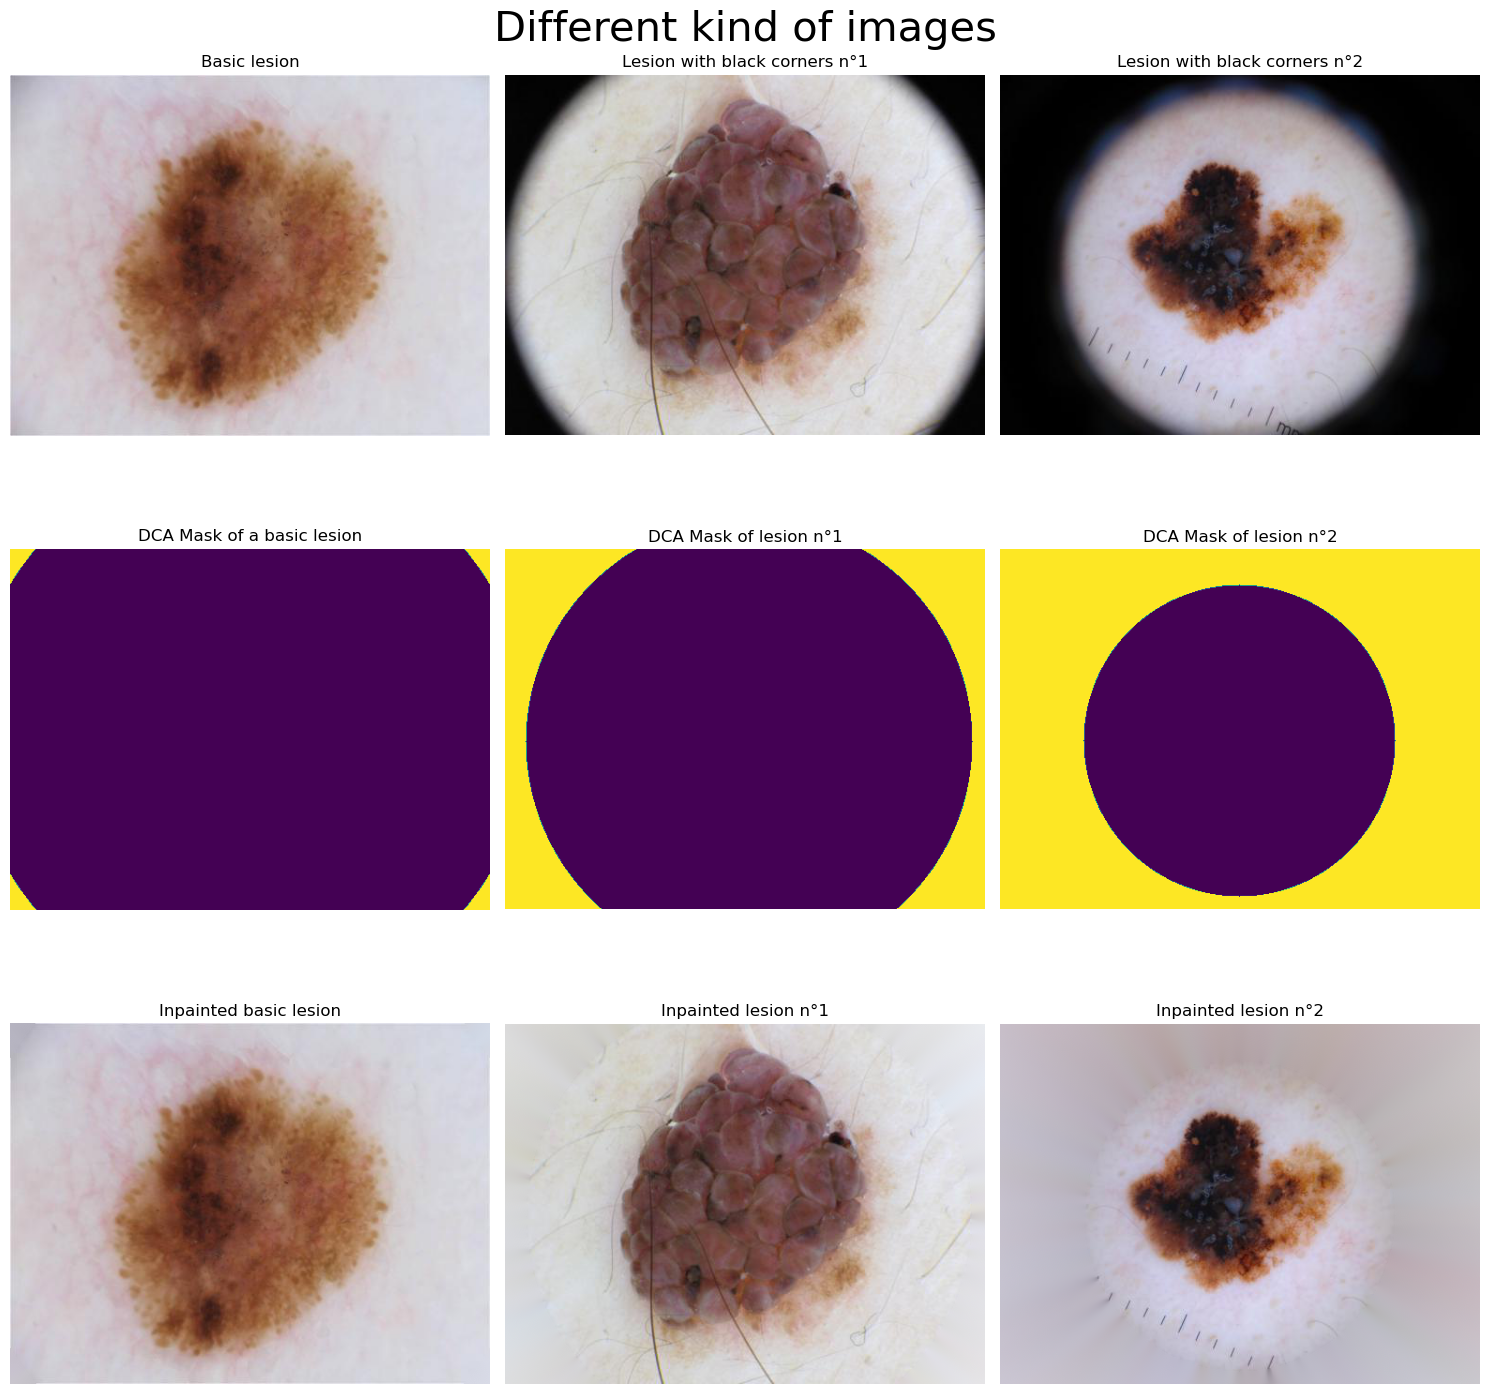

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Créer une grille de 2x4 pour les images

# Charger et afficher la première image
img1 = io.imread('Train/Train/ISIC_0000008.jpg')
axs[0, 0].imshow(img1)
axs[0, 0].set_title('Basic lesion')  # Ajouter un titre
axs[0, 0].axis('off')  # Enlever les axes

# Charger et afficher la deuxième image
inpainted_img1, masque1 = sp.inpainting_dca(img1)
axs[1, 0].imshow(masque1)
axs[1, 0].set_title('DCA Mask of a basic lesion')  # Ajouter un titre
axs[1, 0].axis('off')  # Enlever les axes

axs[2, 0].imshow(inpainted_img1)
axs[2, 0].set_title('Inpainted basic lesion')  # Ajouter un titre
axs[2, 0].axis('off')  # Enlever les axes

# Charger et afficher la troisième image
img3 = io.imread('Train/Train/ISIC_0000100.jpg')
axs[0, 1].imshow(img3)
axs[0, 1].set_title('Lesion with black corners n°1')  # Ajouter un titre
axs[0, 1].axis('off')  # Enlever les axes

# Charger et afficher la quatrième image
inpainted_img2, masque2 = sp.inpainting_dca(img3)
axs[1, 1].imshow(masque2)
axs[1, 1].set_title('DCA Mask of lesion n°1')  # Ajouter un titre
axs[1, 1].axis('off')  # Enlever les axes

axs[2, 1].imshow(inpainted_img2)
axs[2, 1].set_title('Inpainted lesion n°1')  # Ajouter un titre
axs[2, 1].axis('off')  # Enlever les axes

# Charger et afficher la cinquième image
img5 = io.imread('Train/Train/ISIC_0000283.jpg')
axs[0, 2].imshow(img5)
axs[0, 2].set_title('Lesion with black corners n°2')  # Ajouter un titre
axs[0, 2].axis('off')  # Enlever les axes

# Charger et afficher la sixième image
inpainted_img3, masque3 = sp.inpainting_dca(img5)
axs[1, 2].imshow(masque3)
axs[1, 2].set_title('DCA Mask of lesion n°2')  # Ajouter un titre
axs[1, 2].axis('off')  # Enlever les axes

axs[2, 2].imshow(inpainted_img3)
axs[2, 2].set_title('Inpainted lesion n°2')  # Ajouter un titre
axs[2, 2].axis('off')  # Enlever les axes


plt.tight_layout()  # Ajuster l'espacement entre les sous-graphiques

# Ajouter un titre général
fig.suptitle("Different kind of images", fontsize=30)

plt.show()  # Afficher le graphique

### C - Pipeline of Pre-processing

The pre-processing I decided to apply on the picture we have is based on the dullrazor algorithm and on the dark corner removal algorithm. The goal is to remove the hairs and the black corners that could generate troubles during the segmentation and the classification tasks.

In a more complete pipeline, we could also apply the following steps:
- Detect the medical patchs that appears on some of the images
- Detect the purple medical scars
- Then we would inpaint the image to allow a more efficient segmentation, anbd therefore classification through the extraction of feature.


# V - Segmentation

The aim is to build an efficient and robust automatic segmentation tool for skin lesion images. It's evident that these lesions exhibit significant variations in size, color, and contrast relative to the adjacent skin. We already tried to fix somes issues with the preprocessing part (hairs and black corners) but we still have to deal with the color and contrast variations.

A common drawback of many segmentation algorithms is the requirement for user interaction to adjust certain parameters. However, tests conducted on various sample images in a study explained in a scientific article untitled Automated Melanoma Recognition revealed that it's feasible to establish a few segmentation techniques with suitable parameter settings that can segment each individual skin lesion image. The ultimate segmentation is then obtained through a fusion process.

The segmentation algorithm I decided to apply is based on a method explained in the previous article. It is divided in three main algorithms that are employed to segment a lesion: global thresholding, dynamic thresholding, and a 3-D color clustering concept. Optimal results were obtained using the following color channels: thresholding with the blue channel of the RGB color model and the b channel of the CIE-Lab color model, and 3-D color clustering with the X, Y, and Z channels of the CIE-XYZ color model. After morphologic processing of the segmentation results to eliminate minor artifacts, the lesion mask is generated as the largest region within the image.

The funtion use is called five_segmentation and is described in the file segmentation_and_preprocessing.py.
After calculating the five segmentation masks, we will follow the 5 following rules, to determine which mask we keep to make a union at the end.

- Rule I: Segmentation results with the lesion mask growing into the image border are rejected

- Rule II: Segmentation results without any detected region are rejected

- Rule III: Segmentation results comprising fragments at the image borders are rejected

- Rule IV: The segmentation result with the smallest mask is rejected

- Rule V: Segmentation results, whose mask areas differ too much to the other segmentation results are rejected

After the computation of the segmentation we apply the dca mask to remove all the artefact that could have appeared in the inpainted zone.

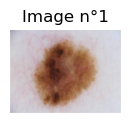

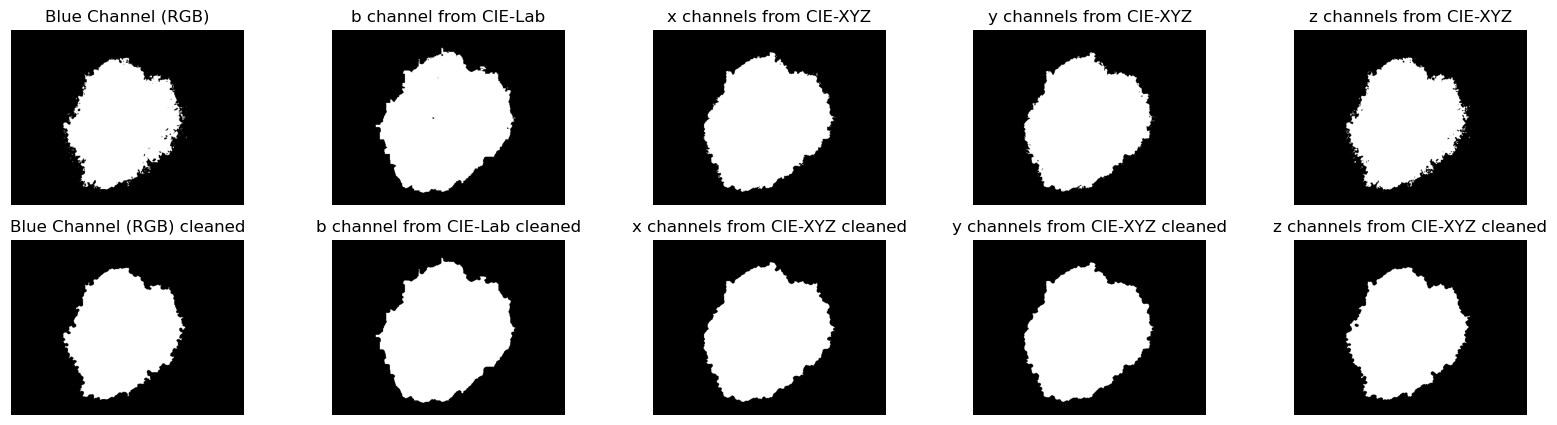

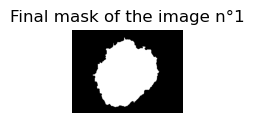

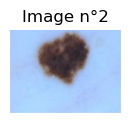

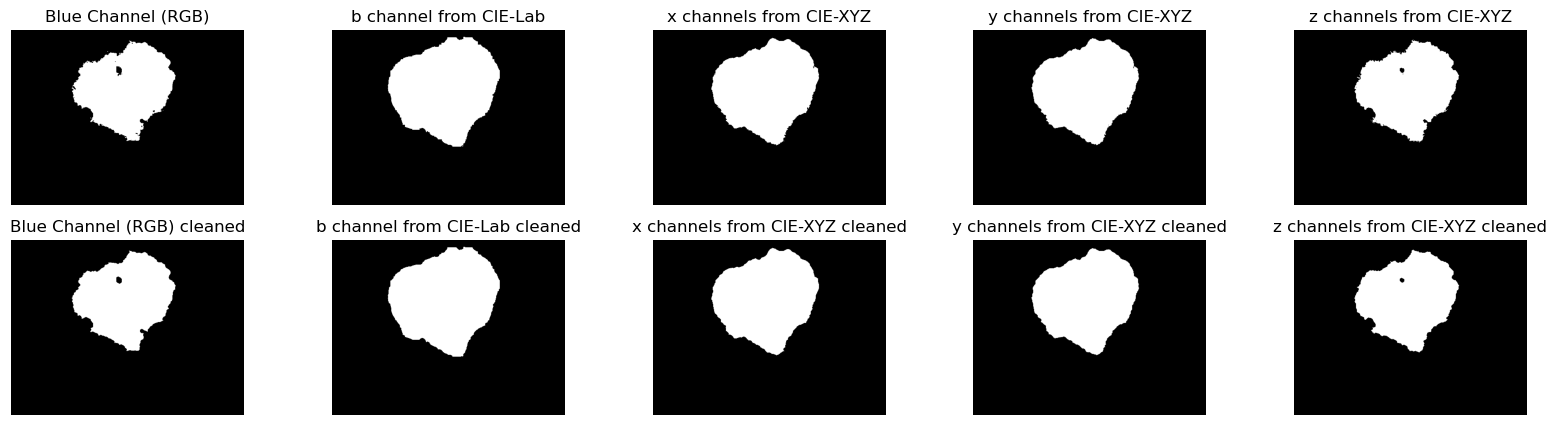

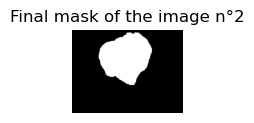

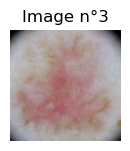

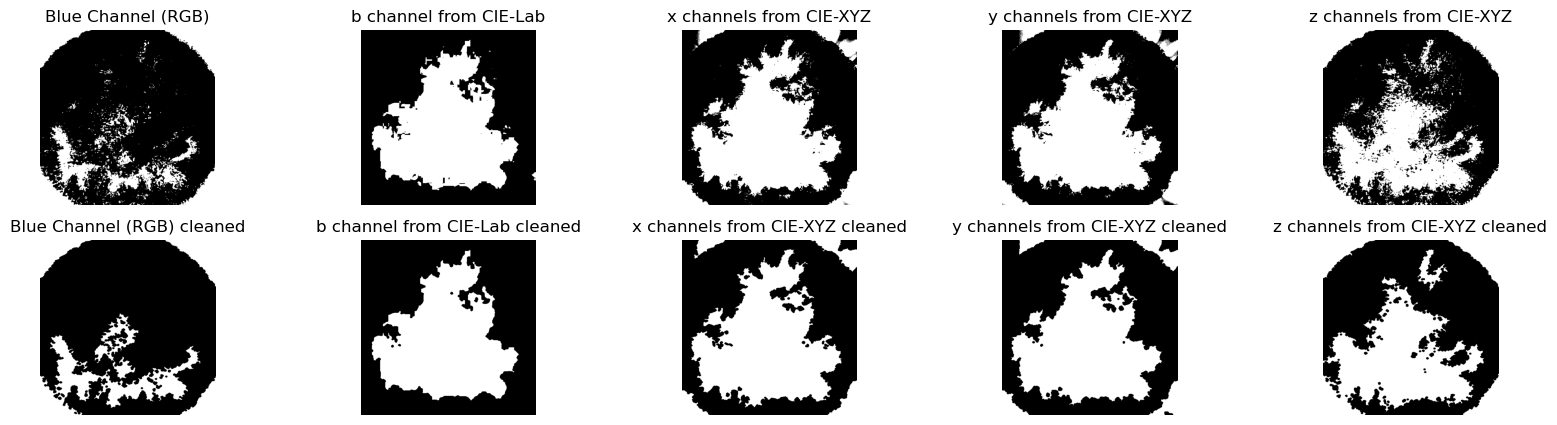

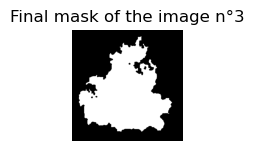

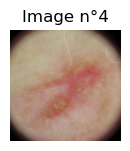

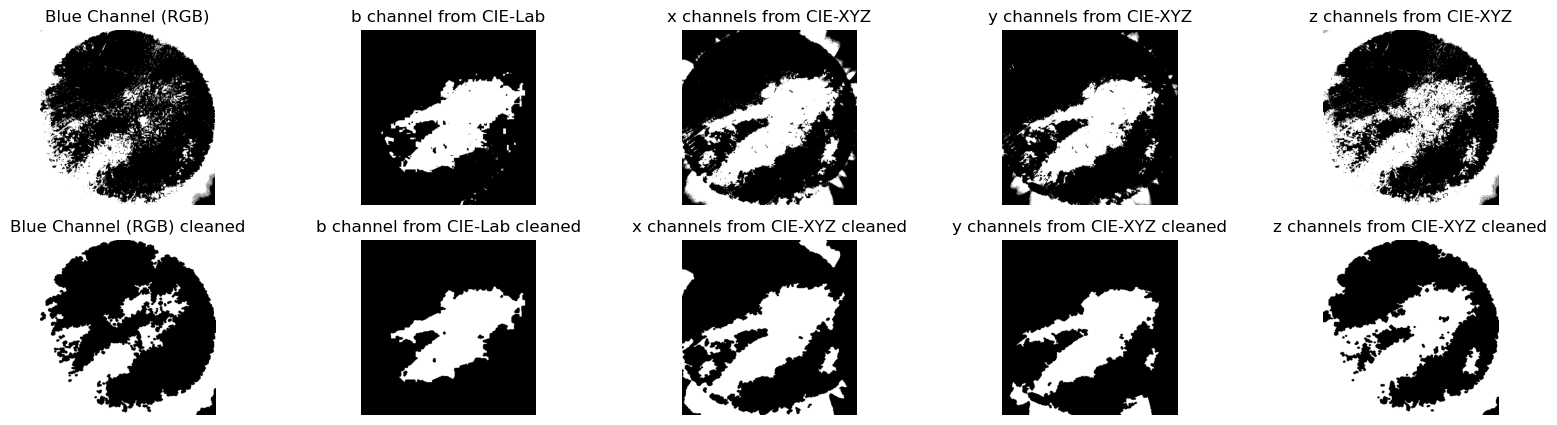

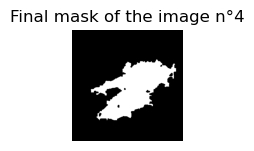

In [9]:
# Liste des images à traiter
img1 = io.imread('Train/Train/ISIC_0000008.jpg')
img2 = io.imread('Train/Train/ISIC_0000016.jpg')
img3 = io.imread('Train/Train/ISIC_0060372.jpg')
img4 = io.imread('Train/Train/ISIC_0065549.jpg')
images = [img1, img2, img3, img4]
# Traitement des images et affichage des résultats
for j,image in enumerate(images):
    image_cleaned = dr.dullrazor(image)
    image_cleaned_rgb = cv.cvtColor(image_cleaned, cv.COLOR_BGR2RGB)  # Convertir en RGB avant d'afficher
    inpainted_img, mask = sp.inpainting_dca(image_cleaned_rgb)
    five_masks = sp.five_segmentation(inpainted_img)
    five_masks_cleaned = sp.remove_small_parts_and_fill(five_masks)
    final_mask = sp.union_mask(five_masks_cleaned)

    # Affichage de l'image originale et des masques
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(image_cleaned_rgb)
    plt.title('Image n°' + str(j + 1))
    plt.axis('off')

    # Affichage des 5 masques
    plt.figure(figsize=(20, 5))

    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(five_masks[i], cmap='gray')
        if i==0:
            plt.title('Blue Channel (RGB)')
        elif i==1:
            plt.title('b channel from CIE-Lab')
        elif i==2:
            plt.title('x channels from CIE-XYZ')
        elif i==3:
            plt.title('y channels from CIE-XYZ')
        else:
            plt.title('z channels from CIE-XYZ')
        plt.axis('off')

    # Affichage des 5 masques après nettoyage
    for i in range(5):
        plt.subplot(2, 5, i+6)
        plt.imshow(five_masks_cleaned[i], cmap='gray')
        if i==0:
            plt.title('Blue Channel (RGB) cleaned')
        elif i==1:
            plt.title('b channel from CIE-Lab cleaned')
        elif i==2:
            plt.title('x channels from CIE-XYZ cleaned')
        elif i==3:
            plt.title('y channels from CIE-XYZ cleaned')
        else:
            plt.title('z channels from CIE-XYZ cleaned')
        plt.axis('off')
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final mask of the image n°' + str(j + 1))
    plt.axis('off')
        
    plt.show()

It is easier to have images with the same format, and as the CNN needs square images, we will resize the images to 256x256 using zero-padding.

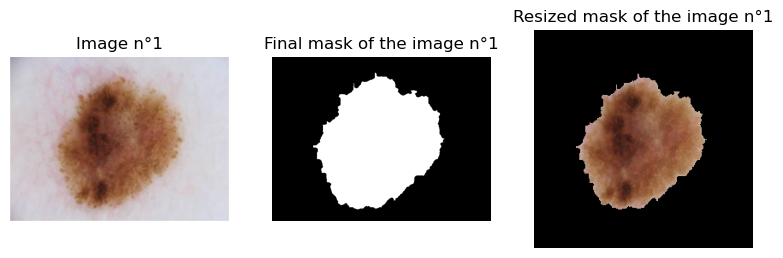

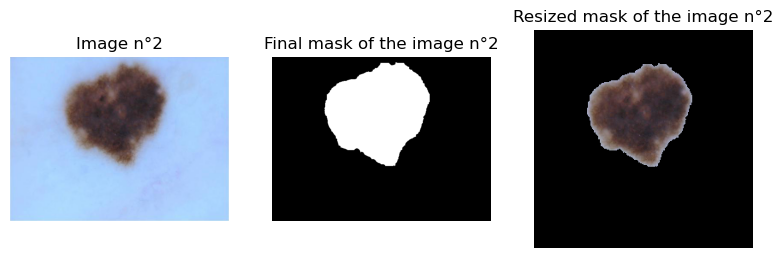

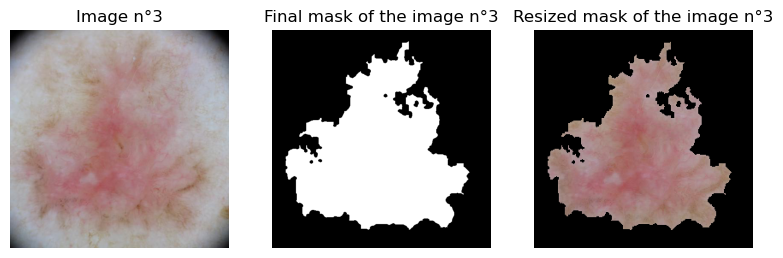

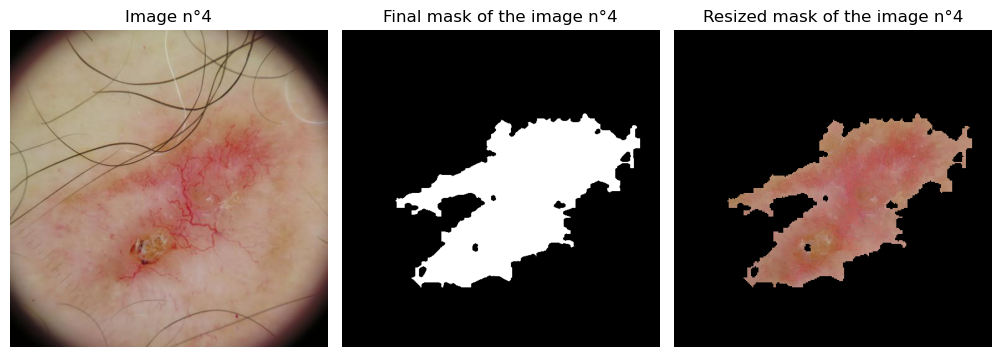

In [10]:
# Traitement des images et affichage des résultats
img1 = 'Train/Train/ISIC_0000008.jpg'
img2 = 'Train/Train/ISIC_0000016.jpg'
img3 = 'Train/Train/ISIC_0060372.jpg'
img4 = 'Train/Train/ISIC_0065549.jpg'
images = [img1, img2, img3, img4]
for j,image_path in enumerate(images):
   image = io.imread(image_path)
   image_cleaned = dr.dullrazor(image)
   image_cleaned = cv.cvtColor(image_cleaned, cv.COLOR_BGR2RGB)
   mask_pred = sp.compute_segmentation(image_path)
   mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
   mask_pred = mask_pred_normalized
   lesions_r = image_cleaned[:,:,0] * mask_pred
   lesions_g = image_cleaned[:,:,1] * mask_pred
   lesions_b = image_cleaned[:,:,2] * mask_pred
   lesions = np.stack([lesions_r, lesions_g, lesions_b], axis=2)
   resized_padded_image = sp.resize_with_padding_binary_mask(lesions, (256, 256))

   # Affichage de l'image originale, du masque final et du masque redimensionné
   plt.figure(figsize=(40, 5))

   plt.subplot(1, 3*len(images), 3*j+1)
   plt.imshow(image)
   plt.title('Image n°' + str(j + 1))
   plt.axis('off')

   plt.subplot(1, 3*len(images), 3*j+2)
   plt.imshow(mask_pred, cmap='gray')
   plt.title('Final mask of the image n°' + str(j + 1))
   plt.axis('off')

   plt.subplot(1, 3*len(images), 3*j+3)
   plt.imshow(resized_padded_image, cmap='gray')
   plt.title('Resized mask of the image n°' + str(j + 1))
   plt.axis('off')
plt.tight_layout()
plt.show()

Des fonctions dans le fichier segmentation_and_preprocessing.py permettent de réaliser cette pipeline sur toutes les images et de les enregistrées dans les fichiers *output_binary_masks_train_set_1* et *output_binary_masks_test_set*.

## Evaluation of the segmentation

  0%|          | 0/1945 [00:00<?, ?it/s]

  1%|          | 17/1945 [00:04<08:42,  3.69it/s]/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_31720/1068055743.py:13: RuntimeWarning: invalid value encountered in divide
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_31720/1068055743.py:13: RuntimeWarning: invalid value encountered in cast
  mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
100%|██████████| 1945/1945 [06:14<00:00,  5.19it/s]

                         nom_image  dice_score
0     Train/Train/ISIC_0014032.jpg    0.271508
1     Train/Train/ISIC_0000067.jpg    0.938644
2     Train/Train/ISIC_0012406.jpg    0.874200
3     Train/Train/ISIC_0015440.jpg    0.740330
4     Train/Train/ISIC_0000077.jpg    0.697561
...                            ...         ...
1940  Train/Train/ISIC_0000366.jpg    0.577100
1941  Train/Train/ISIC_0014576.jpg    0.000000
1942  Train/Train/ISIC_0011228.jpg    0.884618
1943  Train/Train/ISIC_0002353.jpg    0.058844
1944  Train/Train/ISIC_0013458.jpg    0.847552

[1945 rows x 2 columns]


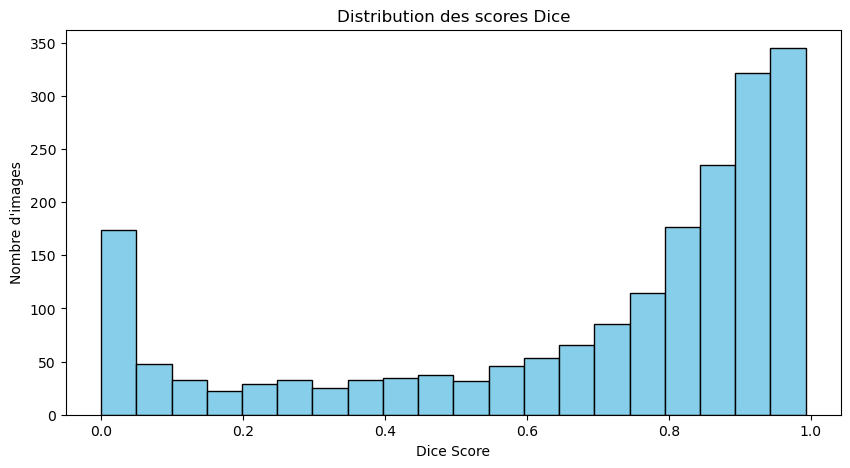

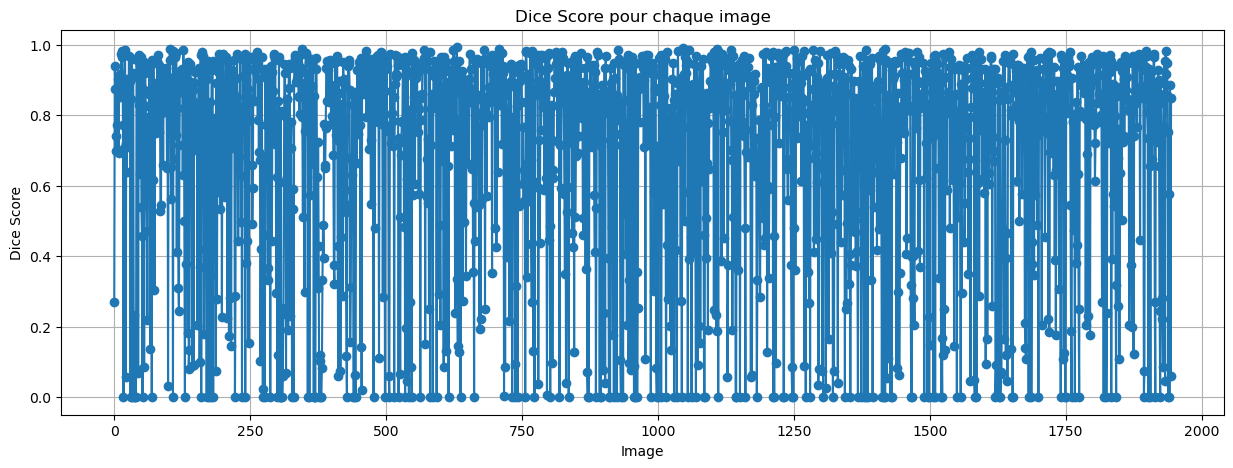

In [11]:
resultats = []
masks_pred_resized = []
# Utilisation de tqdm pour afficher une barre de progression
for i in tqdm(range(0, len(images_with_mask))):
    image = io.imread(images_with_mask[i])
    mask_pred = sp.compute_segmentation(images_with_mask[i])
    mask_true = io.imread(mask_img_train[i])

    mask_pred = mask_pred.astype(np.uint8)
    mask_true = mask_true.astype(np.uint8)

    #normaliser les masks
    mask_pred_normalized = np.array(mask_pred.astype(float) / mask_pred.max()).astype(int)
    mask_true_normalized = np.array(mask_true.astype(float) / mask_true.max()).astype(int)

    dice = sp.dice_score(mask_pred_normalized,mask_true_normalized)
    # Ajouter les résultats à la liste
    masks_pred_resized.append(mask_pred_normalized)
    resultats.append({'nom_image': images_with_mask[i], 'dice_score': dice})

# Convertir la liste en DataFrame
df_resultats = pd.DataFrame(resultats)

# Afficher le DataFrame
print(df_resultats)

#Afficher les résulats sous forme de graphique
plt.figure(figsize=(10, 5))
plt.hist(df_resultats['dice_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Dice Score')
plt.ylabel('Nombre d\'images')
plt.title('Distribution des scores Dice')
plt.show()

#tracer un graphique avec tous les disce score en ordonné et les images en absicess
plt.figure(figsize=(15, 5))
plt.plot(df_resultats['dice_score'], 'o-')
plt.xlabel('Image')
plt.ylabel('Dice Score')
plt.title('Dice Score pour chaque image')
plt.grid()
plt.show()

Wehave a pretty decent result here with the dice score.Among the 1945 images that have been compared, we have only 170 images with a 0 dice score, which means that on these images all the segmentation mask were completely wrong, due for example by the presence of medical patch. However, we have great score on almost 2/3 of the images, which is correct.
It would be possible to improve a lot the results by coding algorithm to take into account medical patch, medical purple scars and all of the artefact that disturb the segmentation algorithm.

The use of a CNN for the segmentation could also be interesting. The best result may be obtained by combining these twoi methods.

## Création des fichiers contenant les masques de segmentation

We divide the process in four parts for not using too much memory of the computer.

In [ ]:
sp.compute_and_save_segmented_lesions(images_train[:len(images_train)//4], 'output_masks_train_set_1', 'output_binary_masks_train_set_1')
sp.compute_and_save_segmented_lesions(images_train[len(images_train)//4 : 2*len(images_train)//4], 'output_masks_train_set_1', 'output_binary_masks_train_set_1')
sp.compute_and_save_segmented_lesions(images_train[2*len(images_train)//4:3*len(images_train)//4], 'output_masks_train_set_1', 'output_binary_masks_train_set_1')
sp.compute_and_save_segmented_lesions(images_train[3*len(images_train)//4:], 'output_masks_train_set_1', 'output_binary_masks_train_set_1')

In [ ]:
sp.compute_and_save_segmented_lesions(images_test, 'output_masks_test_set', 'output_binary_masks_test_set')

# VI - Features extraction (ABCD)

All the features are calculated with the function compute_features in the file compute_features.py.

---


In this notebook, we perform feature extraction on skin lesion images to obtain relevant characteristics that can be used for further analysis and classification. The features we calculate include:

1. **Total Area**: The total area of the lesion is calculated by summing all the pixels in the corresponding mask. This feature is important because the size of a lesion can be indicative of its severity.
2. **Perimeter and Compactness Index**: The perimeter of the lesion is calculated using the `cv2.arcLength()` function on the lesion contour. The compactness index is then calculated as the ratio of the squared perimeter to the product of 4π and the total area. This feature provides information about the shape and regularity of the lesion boundary.
3. **Diameter**: The diameter of the lesion is calculated as the maximum dimension (width or height) of the bounding box around the lesion. This feature is also related to the size of the lesion.
4. **Color Variegation**: The color variegation is calculated as the standard deviation of each color channel (red, green, blue) divided by its maximum value. This feature captures the variability of colors within the lesion.
5. **Texture Features**: The texture features are calculated based on the gray-level co-occurrence matrix (GLCM) of the lesion region. The GLCM captures the spatial relationships between pixels with similar gray-level values. We calculate four texture features: correlation, homogeneity, energy, and contrast. These features provide information about the distribution and variability of gray-level values within the lesion.

The feature extraction process is performed using a custom function called `calculate_features()`. This function takes as input the lists of image paths, mask paths, and lesion paths, and returns a pandas DataFrame containing the calculated features for each image.

---


2it [00:00, 25.07it/s]


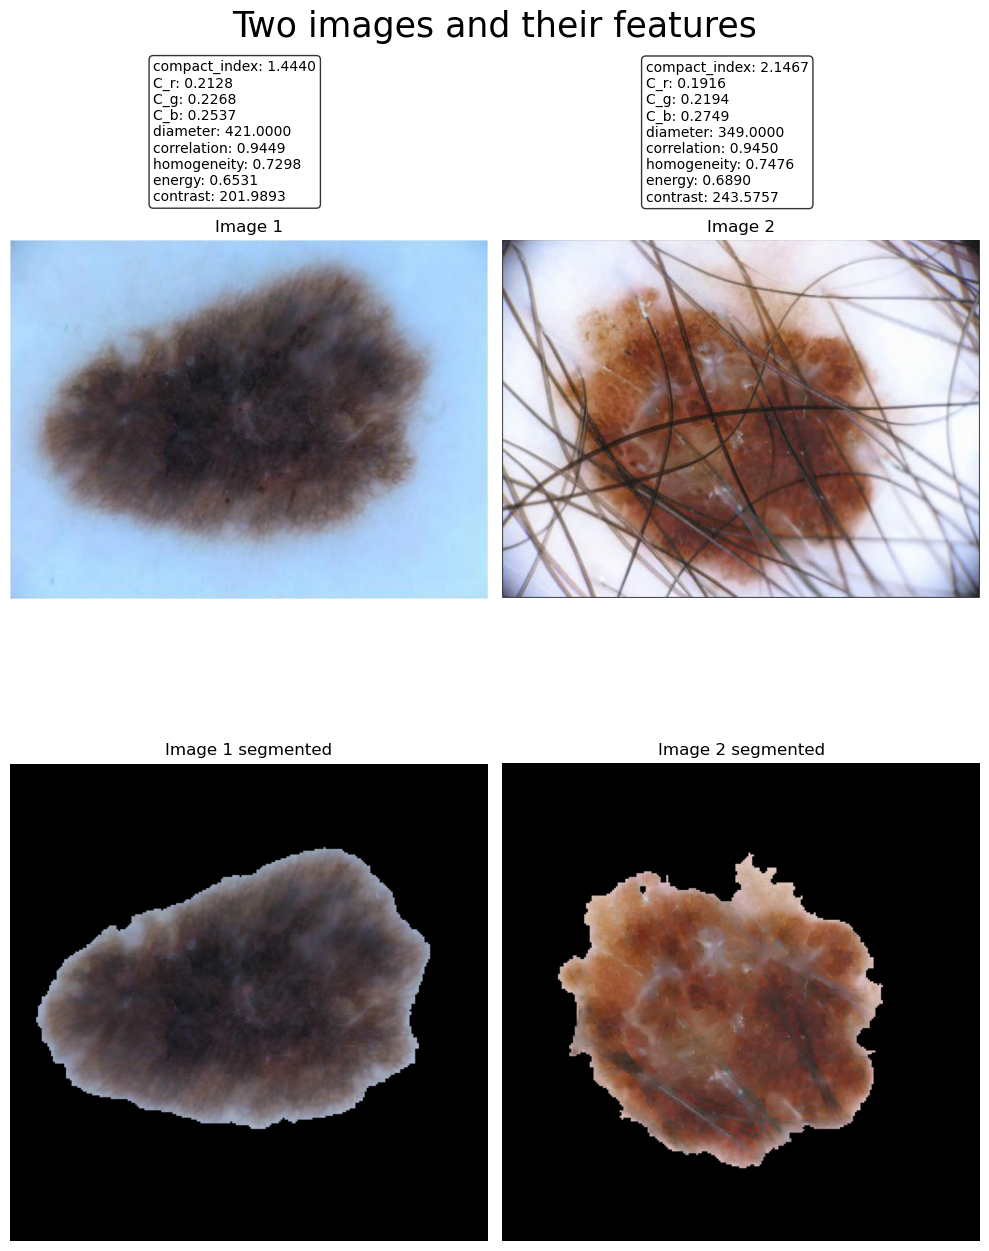

In [14]:

img1 = 'Train/Train/ISIC_0000000.jpg'
lesions1 = 'output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png'
mask1 = 'output_binary_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png'
img2 = 'Train/Train/ISIC_0000043.jpg'
lesions2 = 'output_masks_train_set_1/ISIC_0000043.jpg_pred_mask.png'
mask2 = 'output_binary_masks_train_set_1/ISIC_0000043.jpg_pred_mask.png'

list_img = [img1, img2]
list_mask = [mask1, mask2]
list_lesions = [lesions1, lesions2]

df_features = cf.calculate_features(list_img, list_mask, list_lesions)

fig, axes = plt.subplots(2, 2, figsize=(10, 14))
axes[0, 0].imshow(io.imread(img1))
axes[0, 0].set_title('Image 1')
axes[0, 0].axis('off')
axes[1, 0].imshow(io.imread(lesions1))
axes[1, 0].set_title('Image 1 segmented')
axes[1, 0].axis('off')

axes[0, 1].imshow(io.imread(img2))
axes[0, 1].set_title('Image 2')
axes[0, 1].axis('off')
axes[1, 1].imshow(io.imread(lesions2))
axes[1, 1].set_title('Image 2 segmented')
axes[1, 1].axis('off')

# Display features below each image
for i, (ax, img, lesion, features) in enumerate(zip(axes.flat, list_img, list_lesions, df_features.to_dict('records'))):
    ax.text(0.3, 1.10, '\n'.join([f'{k}: {v:.4f}' for k, v in features.items() if k != 'ID']),
            verticalalignment='bottom', transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
fig.suptitle("Two images and their features", fontsize=25)
plt.show()


# VII - Classification using feature extraction and RandomForest

### A - Reorganising the data structure

In [15]:
# For the TRAIN SET
# Use glob to get a list of all the .png files in the directory 'output_masks_train_set_1'
lesions_segmentes = glob.glob('output_masks_train_set_1/*.png')

# Extract the image file names from the full paths
lesions_segmentes_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in lesions_segmentes]

# Use glob to get a list of all the .png files in the directory 'output_binary_masks_train_set_1'
binary_masks = glob.glob('output_binary_masks_train_set_1/*.png')

# Extract the image file names from the full paths
binary_masks_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in binary_masks]

# Get the names and classes as pandas series from the training metadata
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]

# Convert the pandas series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()


In [16]:
# For the TEST SET
lesions_segmentes_test = glob.glob('output_masks_test_set/*.png')
lesions_segmentes_names_test = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in lesions_segmentes_test]

binary_masks_test = glob.glob('output_binary_masks_test_set/*.png')
binary_masks_names_test = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in binary_masks_test]

# Get the names and classes as pandas Series
names_series_test = metadataTest["ID"].loc[metadataTest["ID"].isin(lesions_segmentes_names_test)]


# Convert the pandas Series to lists
names_list_test = names_series_test.tolist()




In [17]:

print('There are', len(lesions_segmentes),  'segmented lesions train set')
print('There are', len(binary_masks),  'binary masks computed on the train set')
print('There are', len(lesions_segmentes_test),  'segmented lesions test set')
print('There are', len(binary_masks_test),  'binary masks computed on the test set')

There are 18998 segmented lesions train set
There are 18998 binary masks computed on the train set
There are 6333 segmented lesions test set
There are 6333 binary masks computed on the test set


In [18]:
# Reorder the images of the train set
lesions_segmentes_ordered = []
binary_masks_ordered = []
lesions_segmentes_ordered_names = []
binary_masks_ordered_names = []
images_train_ordered = []
for i in range(0, len(names_list)):
    for j in range(0, len(lesions_segmentes_names)):
        if names_list[i] in lesions_segmentes_names[j]:
            lesions_segmentes_ordered.append(lesions_segmentes[j])
            binary_masks_ordered.append(binary_masks[j])
            images_train_ordered.append(images_train[i])
            lesions_segmentes_ordered_names.append(lesions_segmentes_names[j])
            binary_masks_ordered_names.append(binary_masks_names[j])

In [19]:
# Reorder the images of the test set
lesions_segmentes_ordered_test = []
binary_masks_ordered_test = []
lesions_segmentes_ordered_names_test = []
binary_masks_ordered_names_test = []
images_test_ordered = []
for i in range(0, len(names_list_test)):
    for j in range(0, len(lesions_segmentes_names_test)):
        if names_list_test[i] in lesions_segmentes_names_test[j]:
            lesions_segmentes_ordered_test.append(lesions_segmentes_test[j])
            binary_masks_ordered_test.append(binary_masks_test[j])
            images_test_ordered.append(images_test[i])
            lesions_segmentes_ordered_names_test.append(lesions_segmentes_names_test[j])
            binary_masks_ordered_names_test.append(binary_masks_names_test[j])

### B - Filling the NaN values in the metadata

In [20]:
print("         I - Let's print the number of each Sex",end="\n\n")
print(metadataTrain['SEX'].value_counts(),end="\n\n")
print("         II - Let's print the number of each class of Age",end="\n\n")
print(metadataTrain['AGE'].value_counts(),end="\n\n")
print("         III - Let's print the number of each Position",end="\n\n")
print(metadataTrain['POSITION'].value_counts(),end="\n\n")

         I - Let's print the number of each Sex

male      9978
female    8736
Name: SEX, dtype: int64

         II - Let's print the number of each class of Age

45.0    1947
50.0    1860
40.0    1712
55.0    1617
70.0    1579
60.0    1543
65.0    1530
75.0    1353
35.0    1252
80.0    1103
85.0     975
30.0     899
25.0     520
20.0     292
15.0     267
10.0     103
5.0       80
0.0       42
Name: AGE, dtype: int64

         III - Let's print the number of each Position

anterior torso     5194
lower extremity    3738
head/neck          3447
upper extremity    2187
posterior torso    2082
palms/soles         292
oral/genital         46
lateral torso        42
Name: POSITION, dtype: int64



In [21]:
#Count the number of NaN in the columns
print('Number of NaN in the columns:', metadataTrain.isna().sum())

Number of NaN in the columns: ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64


#### Choice on how to fill the NaN values :
- We replace the NaN values in the SEX column with the most frequent value.
- We replace the NaN values in the AGE column with the mean value.
- We replace the NaN values in the LOCALISATION column with a new value 'unknown'.


In [22]:
metadataTrain_filled = metadataTrain
metadataTrain_filled['SEX'] = metadataTrain['SEX'].fillna('male')
#- On remplace les NaN dans la colonne AGE par la valeur moyenne.
metadataTrain_filled['AGE'] = metadataTrain['AGE'].fillna(55.0) #55.0 est la moyenne des âges
#- On remplace les NaN dans la colonne POSITION par une nouvelle catégorie 'unknown'.
metadataTrain_filled['POSITION'] = metadataTrain['POSITION'].fillna('unknown')

In [23]:
metadataTest_filled = metadataTest
metadataTest_filled['SEX'] = metadataTest['SEX'].fillna('male')
metadataTest_filled['AGE'] = metadataTest['AGE'].fillna(55.0) #55.0 est la moyenne des âges
metadataTest_filled['POSITION'] = metadataTest['POSITION'].fillna('unknown')

In [24]:
# Let's verify there is no more NaN
print("Train Set", end="\n\n")
print(metadataTrain_filled.isna().sum(), end="\n\n")
print("Test Set",end="\n\n")
print(metadataTest_filled.isna().sum())

Train Set

ID          0
CLASS       0
SEX         0
AGE         0
POSITION    0
dtype: int64

Test Set

ID          0
SEX         0
AGE         0
POSITION    0
dtype: int64


### C - Performing One-hot encoding

We will now perform one-hot encoding on the categorical columns of a dataset. One-hot encoding is a technique used to represent categorical data as numerical data, which is suitable for machine learning algorithms.


**Create a new DataFrame with one-hot encoded columns**: The code uses the `pd.get_dummies()` function from the pandas library to perform one-hot encoding on the selected categorical columns. This creates a new DataFrame with one-hot encoded columns, where each category is represented by a new binary column (0 or 1).


One-hot encoding is important because many machine learning algorithms can only work with numerical data. By converting categorical data into numerical data using one-hot encoding, we can include categorical features in our machine learning models and improve their accuracy.



In [25]:
# select the categorical columns
categorical_cols = ['SEX', 'AGE', 'POSITION']

# create a new DataFrame with one-hot encoded columns
df_one_hot_train = pd.get_dummies(metadataTrain_filled, columns=categorical_cols)

df_one_hot_test = pd.get_dummies(metadataTest_filled, columns=categorical_cols)

### D - Let's add the features that we computed before

#### Computing the features

In [26]:
feature_dataframe = cf.calculate_features(images_train_ordered, binary_masks_ordered, lesions_segmentes_ordered)

142it [00:02, 49.30it/s]/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/Kaggle Challenge/compute_features.py:86: RuntimeWarning: invalid value encountered in scalar divide
  C_r = np.std(lesion_r) / np.max(lesion_r)
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/Kaggle Challenge/compute_features.py:87: RuntimeWarning: invalid value encountered in scalar divide
  C_g = np.std(lesion_g) / np.max(lesion_g)
/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/Kaggle Challenge/compute_features.py:88: RuntimeWarning: invalid value encountered in scalar divide
  C_b = np.std(lesion_b) / np.max(lesion_b)
18998it [06:18, 50.19it/s]


#### Concatenate the two dataframes (the one with the metadata and the one with the extracted features)

In [27]:
df1=df_one_hot_train
df2=feature_dataframe

df3 = pd.DataFrame(columns=df2.columns)
for i in tqdm(range(len(df1['ID']))):
    for j in range(len(df2['ID'])):
        if df1['ID'][i] == df2['ID'][j]:
            new_row = df2.loc[j]
            df3 = df3.append(new_row, ignore_index=True)
            
df4 = pd.concat([df1, df3.drop(['ID'], axis=1)], axis=1)

  0%|          | 0/18998 [00:00<?, ?it/s]/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_31720/3777907179.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(new_row, ignore_index=True)
100%|██████████| 18998/18998 [26:53<00:00, 11.77it/s]


#### Filling the new NaN values

I decided to fill all the NaN values with the mean

In [28]:
df4['C_r'] = df4['C_r'].fillna(df4['C_r'].mean())
df4['C_g'] = df4['C_g'].fillna(df4['C_g'].mean())
df4['C_b'] = df4['C_b'].fillna(df4['C_b'].mean())
df4['diameter'] = df4['diameter'].fillna(df4['diameter'].mean())
df4['compact_index'] = df4['compact_index'].fillna(df4['compact_index'].mean())

### E - Upsampling the data for creating a balanced training data set for the classes

#### Ici on rééquilibre le dataset en duppliquant les caractéristiques des images de chaque classes

images_class1 : 3391
images_class2 : 9657
images_class3 : 2492
images_class4 : 650
images_class5 : 1968
images_class6 : 179
images_class7 : 190
images_class8 : 471
########## UPSAMPLE ##########
images_class1 : 6782
images_class2 : 9657
images_class3 : 9968
images_class4 : 10400
images_class5 : 7872
images_class6 : 5728
images_class7 : 6080
images_class8 : 7536


Text(0.5, 1.0, 'Distribution of classes after Upsampling')

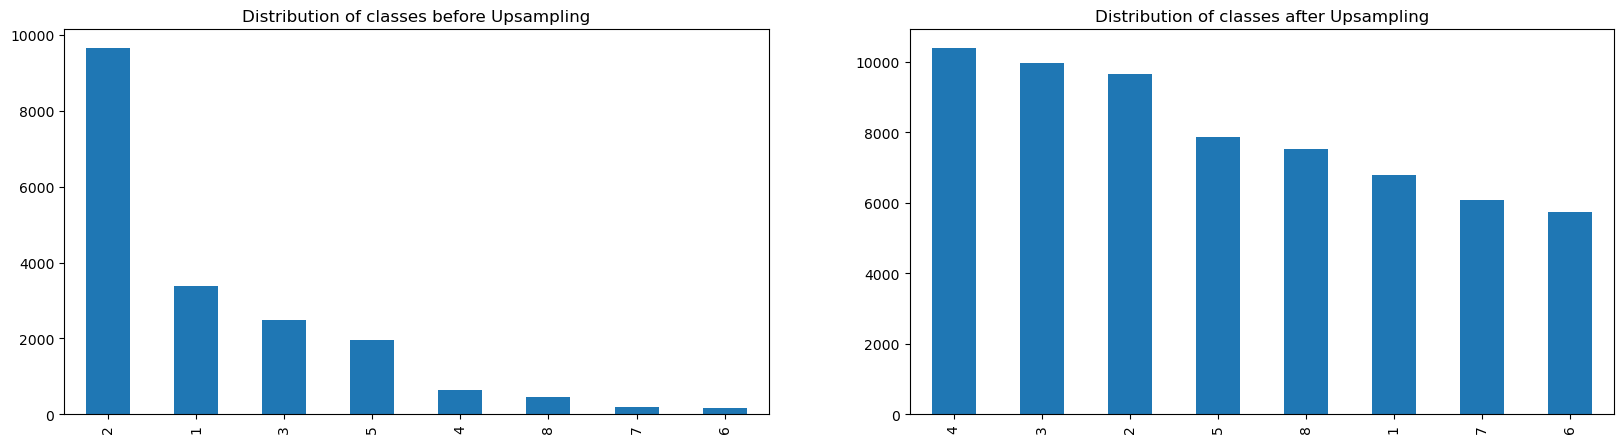

In [29]:
for i in range(1, 9):
    var_name = f"images_class{i}"
    globals()[var_name] = df4[df4['CLASS'] == i]['ID']
    print(f"images_class{i} :", len(globals()[var_name]))

print("########## UPSAMPLE ##########")    
warnings.filterwarnings("ignore", category=FutureWarning)
df4_upsample = df4
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 1])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 3])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 3])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 4])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 4])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 4])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 4])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 5])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 5])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 6])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 6])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 6])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 6])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 6])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 7])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 7])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 7])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 7])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 7])

df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 8])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 8])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 8])
df4_upsample = df4_upsample.append(df4_upsample[df4_upsample['CLASS'] == 8])


for i in range(1, 9):
    var_name = f"images_class{i}"
    globals()[var_name] = df4_upsample[df4_upsample['CLASS'] == i]['ID']
    print(f"images_class{i} :", len(globals()[var_name]))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
df4['CLASS'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribution of classes before Upsampling')

df4_upsample['CLASS'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribution of classes after Upsampling')


#

In [30]:
X = df4_upsample.drop(['ID','CLASS'], axis=1)

y = df4_upsample['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### F - Build the Random Forest Classifier

Accuracy: 0.9568918391253417
classification_report:
               precision    recall  f1-score   support

           1       0.88      0.87      0.87      1312
           2       0.94      0.81      0.87      1920
           3       0.92      0.99      0.96      1988
           4       0.99      1.00      1.00      2083
           5       0.95      0.99      0.97      1597
           6       1.00      1.00      1.00      1108
           7       1.00      1.00      1.00      1234
           8       0.99      1.00      0.99      1563

    accuracy                           0.96     12805
   macro avg       0.96      0.96      0.96     12805
weighted avg       0.96      0.96      0.96     12805



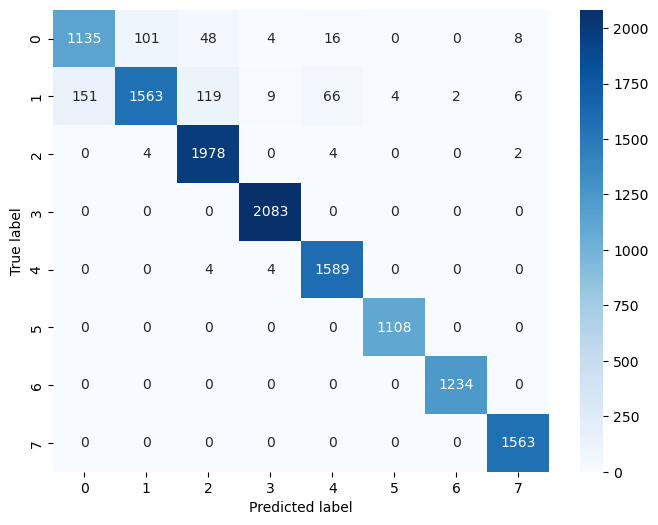

In [31]:
# Création et entraînement du modèle
rf = RandomForestClassifier(n_estimators = 1000,random_state=40)
rf.fit(X_train, y_train)

# Prédiction sur les données de test
y_pred = rf.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_rep = classification_report(y_test, y_pred)

# Affichage des résultats
print("Accuracy:", accuracy)
print("classification_report:\n", class_rep)

# Matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

The confusion matrix gives a result really convincing, with very few errors.

### G - Let's evaluate our results using the Test Set

In [ ]:
feature_dataframe = cf.calculate_features(images_test_ordered, binary_masks_ordered_test, lesions_segmentes_ordered_test)

In [ ]:
df_one_hot_test = pd.get_dummies(metadataTest_filled, columns=categorical_cols)
df1=df_one_hot_test
df2=feature_dataframe

df3 = pd.DataFrame(columns=df2.columns)
for i in tqdm(range(len(df1['ID']))):
    for j in range(len(df2['ID'])):
        if df1['ID'][i] == df2['ID'][j]:
            new_row = df2.loc[j]
            df3 = df3.append(new_row, ignore_index=True)

100%|██████████| 6333/6333 [02:04<00:00, 50.72it/s]


In [ ]:
df4 = pd.concat([df1, df3.drop(['ID'], axis=1)], axis=1)
df4['C_r'] = df4['C_r'].fillna(df4['C_r'].mean())
df4['C_g'] = df4['C_g'].fillna(df4['C_g'].mean())
df4['C_b'] = df4['C_b'].fillna(df4['C_b'].mean())
df4['diameter'] = df4['diameter'].fillna(df4['diameter'].mean())
df4['compact_index'] = df4['compact_index'].fillna(df4['compact_index'].mean())

#### Let's compute the predictions

In [ ]:
X_test = df4.drop(['ID'], axis=1)
y_pred = rf.predict(X_test)

In [ ]:
df_one_hot_test['CLASS'] = y_pred
df_one_hot_test[['ID', 'CLASS']].to_csv('Submission_RF_with_features.csv', index=False)

The results are in the file *Submission_RF_with_features.csv*

# VIII - Convolutional Neural Network for Classification

### A - Introduction to the AlexNet CNN

**AlexNet : une vue d'ensemble**

Un **réseau de neurones artificiels (RNA)** est un modèle d'apprentissage machine paramétrique dont le but principal est d'approximer une fonction \( f : X → Y \), où \( Y = \{C_1, ..., C_k\} \) ou \( Y = au \). Il définit une correspondance \( y = f(x; θ) \) et apprend la valeur des paramètres \( θ \) qui donnent la meilleure approximation de la fonction. Sa structure consiste en une collection d'unités connectées, appelées également *nœuds* ou *neurones artificiels*, organisées en *couches*. La dernière couche est la couche de sortie, tandis que les couches intermédiaires sont appelées couches cachées. Le nombre de couches définit la profondeur du réseau, et la dimensionnalité des couches cachées détermine sa largeur.

Les **réseaux de neurones convolutionnels (CNN)** sont une variante spécialisée des réseaux de neurones artificiels, particulièrement adaptée au traitement d'images. Ils utilisent des opérations de convolution dans au moins une de leurs couches.

AlexNet est un CNN emblématique, conçu par Alex Krizhevsky, Ilya Sutskever et Geoffrey E. Hinton, qui a remporté la compétition ILSVRC 2012. Avec ses 60 millions de paramètres et ses 650 000 neurones, AlexNet a marqué un tournant dans le domaine de la vision par ordinateur.

<figure>
<center>
<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png" width="672"/>
<!--
<img src="https://www.mdpi.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png" width="672"/>
-->
<figcaption>AlexNet architecture</figcaption></center>
</figure>

Sa structure se compose de 5 couches convolutionnelles et 3 couches entièrement connectées. Les caractéristiques distinctives d'AlexNet incluent :

1. **Couches Convolutionnelles** :
   - La première couche convolutionnelle comprend 96 filtres de taille 11 × 11 × 3, suivie d'une couche de *Max Pooling* (sous-échantillonnage maximal) de taille 3 × 3 avec un pas de 2.
   - La deuxième couche convolutionnelle comprend 256 filtres de taille 5 × 5 × 3, également suivie d'une couche de *Max Pooling* de taille 3 × 3 avec un pas de 2.
   - Les troisième et quatrième couches convolutionnelles comprennent chacune 384 filtres de taille 3 × 3 × 3.
   - La cinquième couche convolutionnelle comprend 256 filtres de taille 3 × 3 × 3, suivie d'une autre couche de *Max Pooling* de taille 3 × 3 avec un pas de 2.

2. **Couches Entièrement Connectées** :
   - Les trois dernières couches sont entièrement connectées, avec la dernière couche (la couche de sortie) contenant un nombre de nœuds égal au nombre de classes dans la tâche de classification.

Pour réduire le surajustement, AlexNet utilise deux techniques clés :

- **Augmentation de données** : en appliquant des transformations légères sur les données d'entraînement, telles que des rotations, des translations et des renversements d'images, pour augmenter la taille du jeu de données et améliorer la généralisation du modèle.
  
- **Dropout** : en désactivant aléatoirement certains neurones avec une probabilité de 0,5 lors de l'entraînement, ce qui force le réseau à apprendre des représentations robustes et à éviter la dépendance à des sous-ensembles spécifiques de neurones.

AlexNet utilise la fonction d'activation ReLU après chaque couche convolutionnelle et entièrement connectée, ce qui contribue à l'accélération de l'entraînement grâce à sa propriété de non-saturation et à la facilitation de la convergence du réseau.


### B - Loading the Data and choosing the Machine

Training such a CNN requires a large amount of data and computational ressources. This is why I trained it on the GPU of the school.

In [ ]:
gpu_index = 1

# Configurer TensorFlow pour utiliser le GPU spécifié
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_index], True)
    except RuntimeError as e:
        print(e)

In [ ]:
images_with_mask_names = [os.path.basename(x).split('.')[0] for x in images_with_mask]
binary_masks_ordered = []
binary_masks_ordered_names = []
images_with_mask_ordered = []

for i in range(0, len(images_with_mask)):
    for j in range(0, len(images_with_mask)):
        if images_with_mask_names[i] in mask_img_train[j]:
            images_with_mask_ordered.append(images_with_mask[i])
            binary_masks_ordered.append(mask_img_train[j])
            binary_masks_ordered_names.append(images_with_mask_names[i])
print(len(images_with_mask_ordered))
print(len(binary_masks_ordered))
print(len(binary_masks_ordered_names))


In [ ]:
##TRAIN SET
lesions_segmentes = glob.glob('output_masks_train_set_1/*.png')
lesions_segmentes_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in lesions_segmentes]

binary_masks = glob.glob('output_binary_masks_train_set_1/*.png')
binary_masks_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in binary_masks]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

In [ ]:
##TEST SET
lesions_segmentes_test = glob.glob('output_masks_test_set/*.png')
lesions_segmentes_names_test = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in lesions_segmentes_test]

binary_masks_test = glob.glob('output_binary_masks_test_set/*.png')
binary_masks_names_test = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in binary_masks_test]

# Get the names and classes as pandas Series
names_series_test = metadataTest["ID"].loc[metadataTest["ID"].isin(lesions_segmentes_names_test)]


# Convert the pandas Series to lists
names_list_test = names_series_test.tolist()




In [ ]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')
print('There are', len(lesions_segmentes),  'segmented lesions in the train set')
print('There are', len(binary_masks),  'binary masks coming from the train set')
print('There are', len(lesions_segmentes_test),  'segmented lesions in the test set')
print('There are', len(binary_masks_test),  'binary masks coming from the test set')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks
There are 18998 segmented lesions in the train set
There are 18998 binary masks coming from the train set
There are 6333 segmented lesions in the test set
There are 6333 binary masks coming from the test set


In [ ]:
X_train = lesions_segmentes_ordered
X_train = np.array(X_train)
y_train = classes_list
y_train = np.array(y_train)

### C - Looking at the distribution of the classes and Upsampling the data

In [ ]:
df1=pd.DataFrame(X_train, columns=['ID'])
df2=pd.DataFrame(y_train, columns=['CLASS'])
df = pd.concat([df1, df2], axis=1)

########## UPSAMPLE ##########
images_class1 : 6782
images_class2 : 9657
images_class3 : 9968
images_class4 : 10400
images_class5 : 7872
images_class6 : 5728
images_class7 : 6080
images_class8 : 7536


Text(0.5, 1.0, 'Distribution of classes after Upsampling')

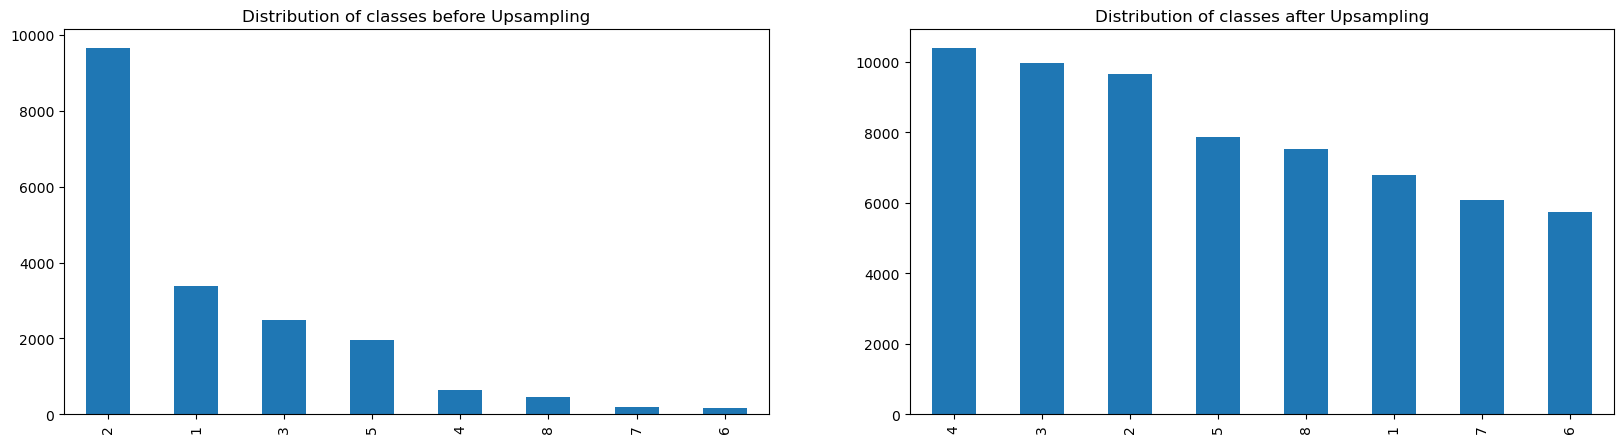

In [ ]:
print("########## UPSAMPLE ##########")    
#dupliquer les lignes pour lesquels les classes sont 6 et 7
df_upsample = df

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 1]])

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 3]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 3]])

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 4]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 4]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 4]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 4]])

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 5]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 5]])


df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 6]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 6]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 6]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 6]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 6]])

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 7]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 7]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 7]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 7]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 7]])

df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 8]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 8]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 8]])
df_upsample = pd.concat([df_upsample, df_upsample[df_upsample['CLASS'] == 8]])

for i in range(1, 9):
    var_name = f"images_class{i}"
    globals()[var_name] = df_upsample[df_upsample['CLASS'] == i]['ID']
    print(f"images_class{i} :", len(globals()[var_name]))

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
df['CLASS'].value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribution of classes before Upsampling')

df_upsample['CLASS'].value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribution of classes after Upsampling')

### D - Preparing the data for the CNN

This step implies creating the right dataframe for the test, validation and training set. It implies giving the right columns, classes.

In [ ]:
X = df_upsample['ID'].to_list()
y = df_upsample['CLASS'].to_list()

#Créer la validation set
# Diviser le jeu de données en train et test set
X_train_val, X_train_test, y_train_val, y_train_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Diviser le train_val set en train et validation set
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=50) # 0.25 * 0.8 = 0.2

print("taille du train set" , len(X_train))
print("taille du validation set" , len(X_train_val))
print("taille du test set" , len(X_train_test))

#créer le csv avec la correspondance nom - class
with open('X_train_ID_class.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(X_train)):
        writer.writerow([X_train[i], y_train[i]])

with open('X_train_val_ID_class.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(X_train_val)):
        writer.writerow([X_train_val[i], y_train_val[i]])

with open('X_train_test_ID_class.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(X_train_test)):
        writer.writerow([X_train_test[i], y_train_test[i]])

df_train = pd.read_csv('X_train_ID_class.csv')
df_train_val = pd.read_csv('X_train_val_ID_class.csv')
df_train_test = pd.read_csv('X_train_test_ID_class.csv')
df_train['CLASS'] = df_train['CLASS'].astype(str)
df_train_val['CLASS'] = df_train_val['CLASS'].astype(str)
df_train_test['CLASS'] = df_train_test['CLASS'].astype(str)


for i in range(len(df_train)):
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('1', 'CLASS1')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('2', 'CLASS2')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('3', 'CLASS3')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('4', 'CLASS4')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('5', 'CLASS5')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('6', 'CLASS6')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('7', 'CLASS7')
    df_train.at[i, 'CLASS'] = df_train.at[i, 'CLASS'].replace('8', 'CLASS8')

for i in range(len(df_train_val)):
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('1', 'CLASS1')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('2', 'CLASS2')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('3', 'CLASS3')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('4', 'CLASS4')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('5', 'CLASS5')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('6', 'CLASS6')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('7', 'CLASS7')
    df_train_val.at[i, 'CLASS'] = df_train_val.at[i, 'CLASS'].replace('8', 'CLASS8')

for i in range(len(df_train_test)):
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('1', 'CLASS1')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('2', 'CLASS2')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('3', 'CLASS3')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('4', 'CLASS4')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('5', 'CLASS5')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('6', 'CLASS6')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('7', 'CLASS7')
    df_train_test.at[i, 'CLASS'] = df_train_test.at[i, 'CLASS'].replace('8', 'CLASS8')


taille du train set 38413
taille du validation set 12805
taille du test set 12805


In [ ]:
X_test = lesions_segmentes_ordered_test
X_test = np.array(X_test)
#dataframe à partir de X_test
df_test = pd.DataFrame(X_test, columns=['ID'])
print(df_test)

                                                     ID
0     output_masks_test_set/ISIC_0055289.jpg_pred_ma...
1     output_masks_test_set/ISIC_0062682.jpg_pred_ma...
2     output_masks_test_set/ISIC_0057706.jpg_pred_ma...
3     output_masks_test_set/ISIC_0031702.jpg_pred_ma...
4     output_masks_test_set/ISIC_0069272.jpg_pred_ma...
...                                                 ...
6328  output_masks_test_set/ISIC_0028560.jpg_pred_ma...
6329  output_masks_test_set/ISIC_0068188.jpg_pred_ma...
6330  output_masks_test_set/ISIC_0072611.jpg_pred_ma...
6331  output_masks_test_set/ISIC_0032918.jpg_pred_ma...
6332  output_masks_test_set/ISIC_0069398.jpg_pred_ma...

[6333 rows x 1 columns]


#### La fonction suivante fait appel à d'autre fonctions décrites dans le fichier AlexNet.py. Elle permet d'entrainer le modèle AlexNet.

In [ ]:
dir_path = ''
class_labels = ['CLASS1', 'CLASS2', 'CLASS3', 'CLASS4', 'CLASS5', 'CLASS6', 'CLASS7', 'CLASS8']
print(df_train.head())
print(df_train_val.head())
print(df_train_test.head())

                                                  ID   CLASS
0  output_masks_train_set_1/ISIC_0025417.jpg_pred...  CLASS3
1  output_masks_train_set_1/ISIC_0066556.jpg_pred...  CLASS4
2  output_masks_train_set_1/ISIC_0026466.jpg_pred...  CLASS8
3  output_masks_train_set_1/ISIC_0055472.jpg_pred...  CLASS5
4  output_masks_train_set_1/ISIC_0034196.jpg_pred...  CLASS7
                                                  ID   CLASS
0  output_masks_train_set_1/ISIC_0071727.jpg_pred...  CLASS8
1  output_masks_train_set_1/ISIC_0028127.jpg_pred...  CLASS1
2  output_masks_train_set_1/ISIC_0067587.jpg_pred...  CLASS5
3  output_masks_train_set_1/ISIC_0058967.jpg_pred...  CLASS4
4  output_masks_train_set_1/ISIC_0031457.jpg_pred...  CLASS6
                                                  ID   CLASS
0  output_masks_train_set_1/ISIC_0060008.jpg_pred...  CLASS3
1  output_masks_train_set_1/ISIC_0027402.jpg_pred...  CLASS1
2  output_masks_train_set_1/ISIC_0054635.jpg_pred...  CLASS4
3  output_masks_train_se

### E - Training the AlexNet model

The `run_alexnet` function below is responsible for training and evaluating the AlexNet model on our image dataset. Here's a detailed breakdown of what it does:

1. **GPU Configuration**: The function first checks the availability of GPUs and configures TensorFlow to use a specified GPU for training.

2. **Data Checking**: It then checks if the necessary data (training, validation, and test dataframes, as well as class labels) is provided.

3. **Data Preprocessing and Training Data Generation**: Depending on the `adv_preproc` parameter, it can perform advanced data preprocessing on the training data (such as feature normalization, rotation, shifting, flipping, zooming, and brightness adjustment) or basic preprocessing (only feature normalization). It then generates a batch of training data using Keras' `ImageDataGenerator` class.

4. **Validation and Test Data Generation**: It also generates batches of data for validation and testing using `ImageDataGenerator`.

5. **Model Creation and Training**: It creates an instance of the AlexNet model, trains it on the training data, and saves the model weights to a file.

6. **Validation Set Evaluation**: After training, it calculates and prints performance metrics (such as accuracy, precision, recall, and f1-score) on the validation set.

7. **Test Set Evaluation**: It also evaluates the trained model on the test set and prints the performance metrics.

8. **Classification Report and Confusion Matrix**: Finally, it prints the classification report for the test set and plots the confusion matrix for a more detailed evaluation.

In summary, this function handles the entire deep learning pipeline, from data preparation to model evaluation.


In [ ]:
def run_alexnet(train_dataframe, val_dataframe, test_dataframe, class_labels, dir_path, batch_size, rand_seed, num_epochs, weights_filename, gpu_index, adv_preproc=False):

    """
    This function trains the AlexNet model and evaluates it on the test set.
    :param train_dataframe: The dataframe for the training set.
    :param val_dataframe: The dataframe for the validation set.
    :param test_dataframe: The dataframe for the test set.
    :param class_labels: The labels for each class.
    :param dir_path: The directory path for the images.
    :param batch_size: The batch size for training.
    :param rand_seed: The random seed for reproducibility.
    :param num_epochs: The number of epochs for training.
    :param weights_filename: The filename to save the model weights.
    :param gpu_index: The index of the GPU to use.
    :param adv_preproc: Whether to use advanced preprocessing for the training set.
    """

    print('{:-<50}'.format(""))
    print("Image classification using AlexNet CNN classifier:")



    # Configurer TensorFlow pour utiliser le GPU spécifié
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_visible_devices(gpus[gpu_index], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[gpu_index], True)
        except RuntimeError as e:
            print(e)


    if class_labels is None:
        print("Error: 'class_labels' cannot be None")
        return
    
    if train_dataframe is None:
        print("Error: 'train_dataframe' cannot be None")
        return
    
    if test_dataframe is None:
        print("Error: 'test_dataframe' cannot be None")
        return

    num_samples_train = train_dataframe['ID'].count()
    
    if adv_preproc:
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           # featurewise_std_normalization=True,
                                           rotation_range=180,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True,
                                           zoom_range=0.15,
                                           brightness_range=[0.8, 1.2],
                                           data_format='channels_last')
    else:
        # Use ImageDataGenerator class to build an image generator for the training set.
        # It will also rescale the pixel values between 0 and 1, that is by multiplying
        # them by a factor of 1/255 since our original images consist in RGB coefficients
        # in [0, 255], but such values would be too high for our model to process.
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           data_format='channels_last')
        
    train_iterator = train_datagen.flow_from_dataframe(train_dataframe,
                                                       directory=dir_path,
                                                       x_col='ID',
                                                       y_col='CLASS',
                                                       target_size=(227, 227),
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=rand_seed)

    # Use ImageDataGenerator class to build an image generator to be used for model validation.
    # It will use the test set images as input data
    valid_datagen = ImageDataGenerator(rescale=1. / 255,
                                       data_format='channels_last')
        
    validation_iterator = valid_datagen.flow_from_dataframe(val_dataframe,
                                                            directory=dir_path,
                                                            x_col='ID',
                                                            y_col='CLASS',
                                                            target_size=(227, 227),
                                                            batch_size=batch_size,
                                                            color_mode='rgb',
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            seed=rand_seed)
        
    # Use ImageDataGenerator class to build an image generator to be used for
    # performance evaluation.
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      data_format='channels_last')

    test_iterator = test_datagen.flow_from_dataframe(test_dataframe,
                                                     directory=dir_path,
                                                     x_col='ID',
                                                     y_col='CLASS',
                                                     target_size=(227, 227),
                                                     batch_size=1,
                                                     class_mode='categorical',
                                                     shuffle=False)
    # create a Metrics instance for validation
    metrics = an.Metrics(validation_iterator)

    # build AlexNet model
    model = an.AlexNet(len(class_labels))

    # print model summary
    model.summary()

    # train the AlexNet CNN
    try:
        history = model.fit_generator(train_iterator,
                                      epochs=num_epochs,
                                      steps_per_epoch=num_samples_train // batch_size,
                                      verbose=1,
                                      callbacks=[metrics])
    except KeyboardInterrupt:
        pass

    model.save(weights_filename)
    print('\nModel weights saved successfully on file {name}\n'.format(name=weights_filename))

    # print and plot mean values of performance metrics related to the Validation set
    print('*** VALIDATION SET PERFORMANCE EVALUATION ***')
    print('Mean accuracy: {:.3f}'.format(np.mean(metrics.accuracy)))
    print('Mean precision: {:.3f}'.format(np.mean(metrics.precisions)))
    print('Mean recall: {:.3f}'.format(np.mean(metrics.recalls)))
    print('Mean f1-score: {:.3f}'.format(np.mean(metrics.f1_scores)))
    
    an.plot_history(history, metrics)

    # *** TEST SET PERFORMANCE EVALUATION ***
    # get prediction on test data
    y_pred = model.predict_generator(test_iterator, steps=len(test_iterator), verbose=1)
    y_pred = np.argmax(y_pred, axis=1)

    # compute and plot performance metrics values for each class
    accuracy = accuracy_score(test_iterator.classes, y_pred)
    val_f1 = f1_score(test_iterator.classes, y_pred, average='weighted')
    val_recall = recall_score(test_iterator.classes, y_pred, average='weighted')
    val_precision = precision_score(test_iterator.classes, y_pred, average='weighted')

    print('*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1-score: {:.3f}'.format(val_f1))
    print('Recall: {:.3f}'.format(val_recall))
    print('Precision: {:.3f}'.format(val_precision))

    # print classification report and plot confusion matrix
    print('\nClassification Report')
    print( classification_report(test_iterator.classes, y_pred))

    an.plot_confusion_matrix(test_iterator.classes, y_pred, class_labels)

We train the model with batch of 64 images, for 55 epochs.

In [ ]:
#runalexnet(dataframe_train, dataframe_test, class_labels, dir_path, batch_size, rand_seed, num_epochs, weights_filename, adv_preproc=False)
run_alexnet(df_train, df_train_val, df_train_test, class_labels, dir_path, 64, 0, 55, 'weights_filename_Alex_Net_upsampled_55epochs', 1, adv_preproc=True)

The following coding cell loads the weights of the model we trained and computes on a testing set the results. It then plot a confusion matrix. The result are encouraging.

---
# Due to the limited size of the file we can ipload on ecampus, I decided not to upload the weights of the model on ecampus but you can downlaod it via this link : https://we.tl/t-W4eESsxrgv
---

2024-05-05 19:26:28.026090: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open weights_filename_Alex_Net_upsampled_55epochs: FAILED_PRECONDITION: weights_filename_Alex_Net_upsampled_55epochs; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Found 12805 validated image filenames belonging to 8 classes.
    1/12805 [..............................] - ETA: 27:54

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_55560/3668318718.py:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_iterator, steps=len(test_iterator), verbose=1)


12805/12805 [==============================] - 181s 14ms/step
*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***
Accuracy: 0.784
F1-score: 0.776
Recall: 0.784
Precision: 0.791

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.38      0.52      1354
           1       0.66      0.81      0.73      1911
           2       0.77      0.65      0.70      1977
           3       0.86      0.81      0.84      2144
           4       0.62      0.74      0.67      1560
           5       0.93      0.99      0.96      1166
           6       0.94      0.99      0.97      1170
           7       0.82      0.97      0.89      1523

    accuracy                           0.78     12805
   macro avg       0.80      0.79      0.78     12805
weighted avg       0.79      0.78      0.78     12805



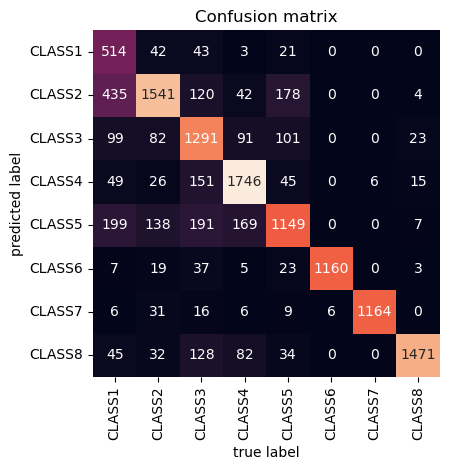

In [ ]:
# Load the saved model weights
model = an.AlexNet(len(class_labels))
model.load_weights('weights_filename_Alex_Net_upsampled_55epochs')

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      data_format='channels_last')
test_iterator = test_datagen.flow_from_dataframe(df_train_test,
                                                     directory=dir_path,
                                                     x_col='ID',
                                                     y_col='CLASS',
                                                     target_size=(227, 227),
                                                     batch_size=1,
                                                     class_mode='categorical',
                                                     shuffle=False)

# *** TEST SET PERFORMANCE EVALUATION ***
# get prediction on test data
y_pred = model.predict_generator(test_iterator, steps=len(test_iterator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

# compute and plot performance metrics values for each class
accuracy = accuracy_score(test_iterator.classes, y_pred)
val_f1 = f1_score(test_iterator.classes, y_pred, average='weighted')
val_recall = recall_score(test_iterator.classes, y_pred, average='weighted')
val_precision = precision_score(test_iterator.classes, y_pred, average='weighted')

print('*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***')
print('Accuracy: {:.3f}'.format(accuracy))
print('F1-score: {:.3f}'.format(val_f1))
print('Recall: {:.3f}'.format(val_recall))
print('Precision: {:.3f}'.format(val_precision))

# print classification report and plot confusion matrix
print('\nClassification Report')
print( classification_report(test_iterator.classes, y_pred))

an.plot_confusion_matrix(test_iterator.classes, y_pred, class_labels)

### F - Computing the prediction of the test set and creating a csv file with the submission

In [ ]:
model = an.AlexNet(len(class_labels))
model.load_weights('weights_filename_Alex_Net_upsampled_55epochs')

# Build an image generator for the new test set
new_test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      data_format='channels_last')

new_test_iterator = new_test_datagen.flow_from_dataframe(df_test,
                                                         directory=dir_path,
                                                         x_col='ID',
                                                         target_size=(227, 227),
                                                         batch_size=1,
                                                         class_mode=None,
                                                         shuffle=False)

# Generate predictions for the new test set
y_pred = model.predict_generator(new_test_iterator, steps=len(new_test_iterator), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

2024-05-05 19:30:49.472844: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open weights_filename_Alex_Net_upsampled_55epochs: FAILED_PRECONDITION: weights_filename_Alex_Net_upsampled_55epochs; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Found 6333 validated image filenames.
   5/6333 [..............................] - ETA: 1:29 

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_55560/3489007921.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(new_test_iterator, steps=len(new_test_iterator), verbose=1)


6333/6333 [==============================] - 90s 14ms/step


In [ ]:
y_pred_updated =y_pred + 1

def extract_image_name(filename):
    return os.path.basename(filename).split('.jpg_pred_mask.png')[0]
df_test['ID'] = df_test['ID'].apply(extract_image_name)

In [ ]:
#ecrire les résultats dans un csv sous la forme ID, CLASS
#trasnformer ID pour garder que le nom de l'image


with open('SampleSubmission_AlexNet_55epochscsv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(df_test)):
        writer.writerow([df_test['ID'][i], y_pred_updated[i]])

### G - Observation of the features extracted by the CNN

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'Features 4')

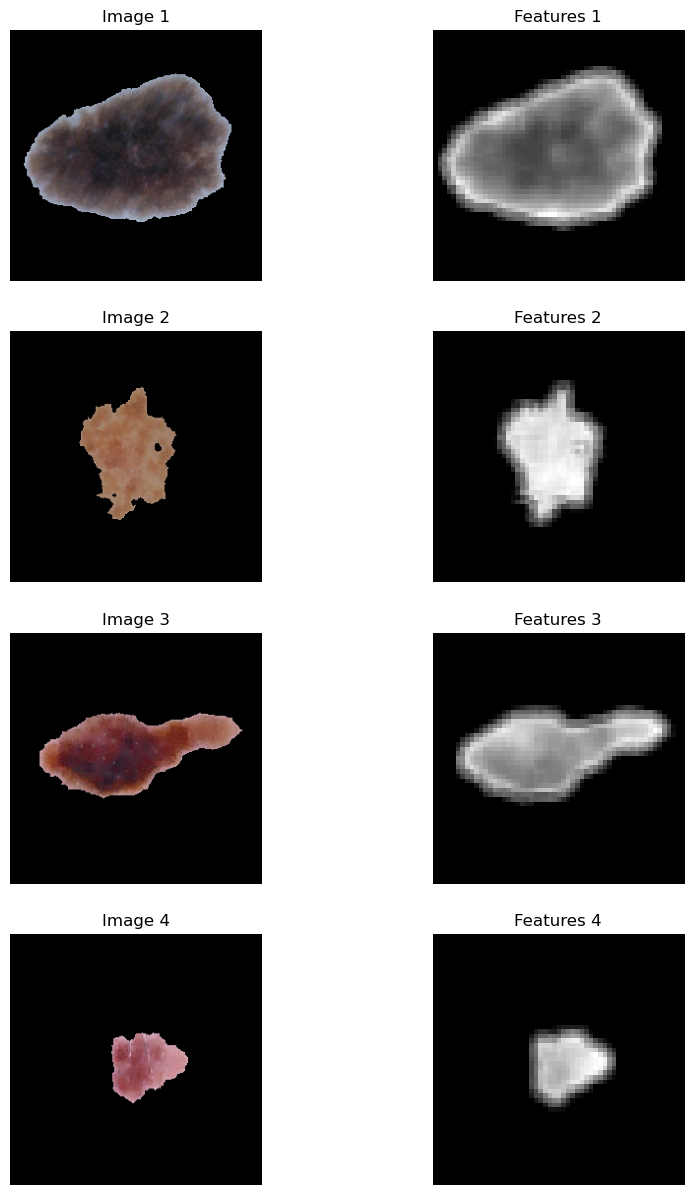

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from tensorflow.keras.preprocessing import image

# Définissez la fonction pour extraire les features d'une couche donnée
def extract_features(model, layer_name):
    # Créez un nouveau modèle qui extrait les features de la couche spécifiée
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return intermediate_layer_model

# Chargez le modèle AlexNet entraîné
model = load_model('weights_filename_Alex_Net_upsampled_55epochs')

# Spécifiez la couche dont vous voulez extraire les features
layer_name = 'conv2d'

# Créez le modèle pour extraire les features de la couche spécifiée
feature_extractor = extract_features(model, layer_name)

img1 = "output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png"
img2 = "output_masks_train_set_1/ISIC_0014221.jpg_pred_mask.png"
img3 = "output_masks_train_set_1/ISIC_0027729.jpg_pred_mask.png"
img4 = "output_masks_train_set_1/ISIC_0028194.jpg_pred_mask.png"

img_list = [img1, img2, img3, img4]
features_list = []

fig,axs = plt.subplots(4,2,figsize=(10,15))
axs[0,0].imshow(io.imread(img1))
axs[0,0].axis('off')
axs[0,0].set_title('Image 1')

axs[1,0].imshow(io.imread(img2))
axs[1,0].axis('off')
axs[1,0].set_title('Image 2')

axs[2,0].imshow(io.imread(img3))
axs[2,0].axis('off')
axs[2,0].set_title('Image 3')

axs[3,0].imshow(io.imread(img4))
axs[3,0].axis('off')
axs[3,0].set_title('Image 4')

for img in img_list:
    img = tf.keras.preprocessing.image.load_img(img, target_size=(227, 227))

    # Convertissez l'image en un tableau NumPy et ajoutez une dimension pour le lot
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalisez l'image en utilisant les moyennes et écarts-types de l'ensemble d'entraînement (par exemple, pour ImageNet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img_array /= 255.0
    img_array -= mean
    img_array /= std

    # Extrayez les features de l'image en utilisant le modèle
    features = feature_extractor.predict(img_array)
    features_list.append(features)

axs[0,1].imshow(features_list[0][0, :, :, 0], cmap='gray')
axs[0,1].axis('off')
axs[0,1].set_title('Features 1')

axs[1,1].imshow(features_list[1][0, :, :, 0], cmap='gray')
axs[1,1].axis('off')
axs[1,1].set_title('Features 2')

axs[2,1].imshow(features_list[2][0, :, :, 0], cmap='gray')
axs[2,1].axis('off')
axs[2,1].set_title('Features 3')

axs[3,1].imshow(features_list[3][0, :, :, 0], cmap='gray')
axs[3,1].axis('off')
axs[3,1].set_title('Features 4')

# CONCLUSION

The result of the classification task on Kaggle appeared to be near 0.48, which is not as good as expected. AsI see it, lots of improvement could be done by improving the segmentation. Indeed, bad segmentation mask implies an inneficient training of the CNN which leads to disappointing results.
An other good improvement could be obtained by using the results of the Random Forest and giving them to the fully connected layer part of the CNN.